In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv
/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv


In [2]:
# Importing all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob




In [3]:
from wordcloud import WordCloud

In [4]:
from nltk.corpus import stopwords
from collections import Counter
import nltk
import re
import string
from string import punctuation
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


In [5]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

stopwords = set(stopwords.words("english"))
punctuation = punctuation + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [6]:
# Importing the datasets

df_train = pd.read_csv("/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv")
df_test = pd.read_csv("/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv") 

print ("The shape of the train set given is : ", df_train.shape)
print ("The shape of the test set given is : ", df_test.shape)

df_train.head()

The shape of the train set given is :  (161297, 7)
The shape of the test set given is :  (53766, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [7]:
# Printing data_types
df_train.dtypes


uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

# Combining both the datasets for preprocessing, later we will split it


In [8]:
df_data = pd.concat([df_train, df_test])

print(df_data.shape)
df_data.head(10)

(215063, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [9]:
df_data.describe()

,uniqueID,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


From the mean value of rating (6.99) we can conclude that this data is not imbalanced one. We can use it for training the machine learning models

In [10]:
# Printing null values in the dataset

print("Null values in the dataset - ", df_data.isnull().sum(axis=0))

Null values in the dataset -  uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64


Condition column has missing values. We can impute that or drop the column.

In [11]:
# Calculating the percentage of data null

size = df_data.shape[0]

print("Total size of data - ", size)
total_na = df_data.isnull().sum(axis=0)['condition']
print("Null values:", total_na)

print("Percentage null values:", (total_na/size)*100)

Total size of data -  215063
Null values: 1194
Percentage null values: 0.5551861547546533


In [12]:
# Dropping the null values in dataset, as it is less than 5%

df_data = df_data.dropna(how='any', axis=0)


In [13]:

print("Shape of the data after null values removal: ", df_data.shape)

Shape of the data after null values removal:  (213869, 7)


In [14]:
# Lowercasing the column names for better processing and ease of use
df_data.columns = df_data.columns.str.lower()

In [15]:
# Sorting the dataframe in ascending values of uniqueId and resetting the index

df_data.sort_values(['uniqueid'], ascending=True, inplace=True)
df_data.reset_index(drop=True, inplace=True)
df_data.head(10)

,uniqueid,drugname,condition,review,rating,date,usefulcount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,27-Oct-15,11
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,26-Oct-15,12
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,25-Oct-15,4
5,6,Medroxyprogesterone,Birth Control,"""This is a horrible shot!! I got my first shot...",1,24-Oct-15,3
6,7,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 18 and got this for heavy bleeding. ...",5,22-Oct-15,6
7,8,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Im 19 and have been having heavy and painful ...",5,21-Oct-15,2
8,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,21-Oct-15,5
9,10,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 years old and I got shot in Augus...",7,20-Oct-15,2


In [16]:
# Finding total unique conditions in dataset

print(df_data['condition'].nunique(),'\n')
# Print 10 unique conditons
print("Few unique condtions are - ", df_data['condition'].unique()[:10])

916 

Few unique condtions are -  ['Abnormal Uterine Bleeding' 'Amenorrhea' 'Birth Control' 'Endometriosis'
 'Endometrial Hyperplasia, Prophylaxis' 'Renal Cell Carcinoma'
 'Not Listed / Othe' 'Eye Redness' 'Benign Prostatic Hyperplasia' 'Acne']


In [17]:
# Top 10 drugs with rating 1
df_data.loc[df_data['rating'] == 1, :]['drugname'].value_counts().head(10)

Miconazole                            767
Ethinyl estradiol / norethindrone     728
Etonogestrel                          707
Levonorgestrel                        511
Nexplanon                             504
Ethinyl estradiol / norgestimate      464
Medroxyprogesterone                   443
Depo-Provera                          417
Tioconazole                           410
Ethinyl estradiol / levonorgestrel    385
Name: drugname, dtype: int64

In [18]:
# Count of the drugs for which usefulcount is 0

df_data.loc[df_data['usefulcount'] == 0, 'drugname'].value_counts()

Etonogestrel                         590
Levonorgestrel                       473
Ethinyl estradiol / norethindrone    371
Implanon                             327
Ethinyl estradiol / norgestimate     252
                                    ... 
Mysoline                               1
Carisoprodol                           1
Chlorpheniramine / hydrocodone         1
Gentamicin                             1
Dilaudid                               1
Name: drugname, Length: 1487, dtype: int64

In [19]:
# Minimum rating in the dataset
df_data['rating'].min()

1

In [20]:
# Converting the date in date format from object
df_data['date'] = pd.to_datetime(df_data['date'])

# Exploratory data analysis


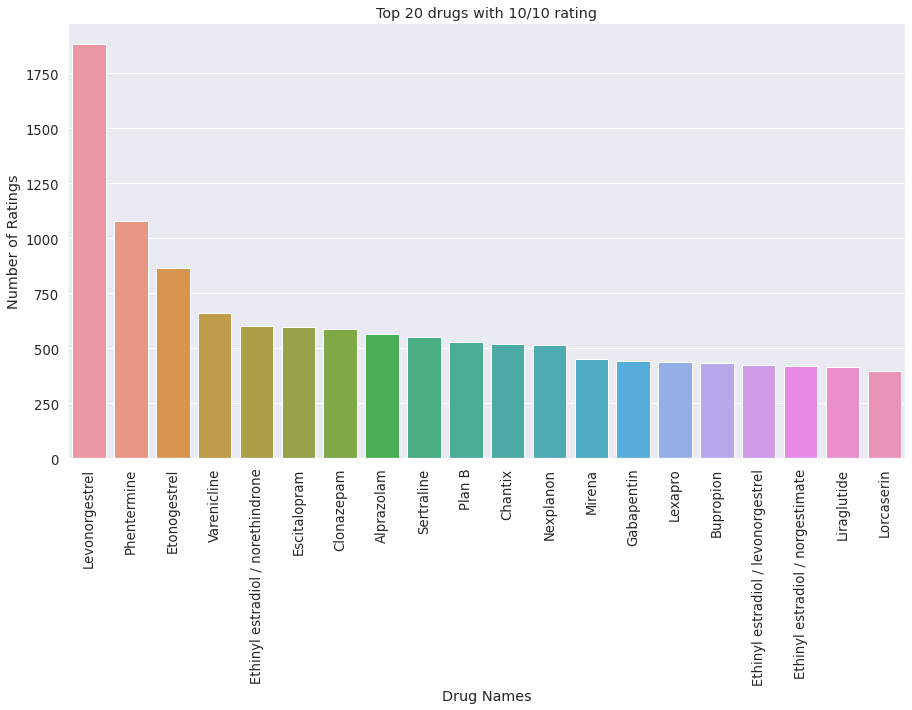

In [21]:
# This bar plot shows top 10 rows in dataset with 10/10 rating

# Setting the parameters first
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df_data.loc[df_data.rating == 10, "drugname"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set(title = 'Top 20 drugs with 10/10 rating', ylabel = 'Number of Ratings', xlabel = "Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);


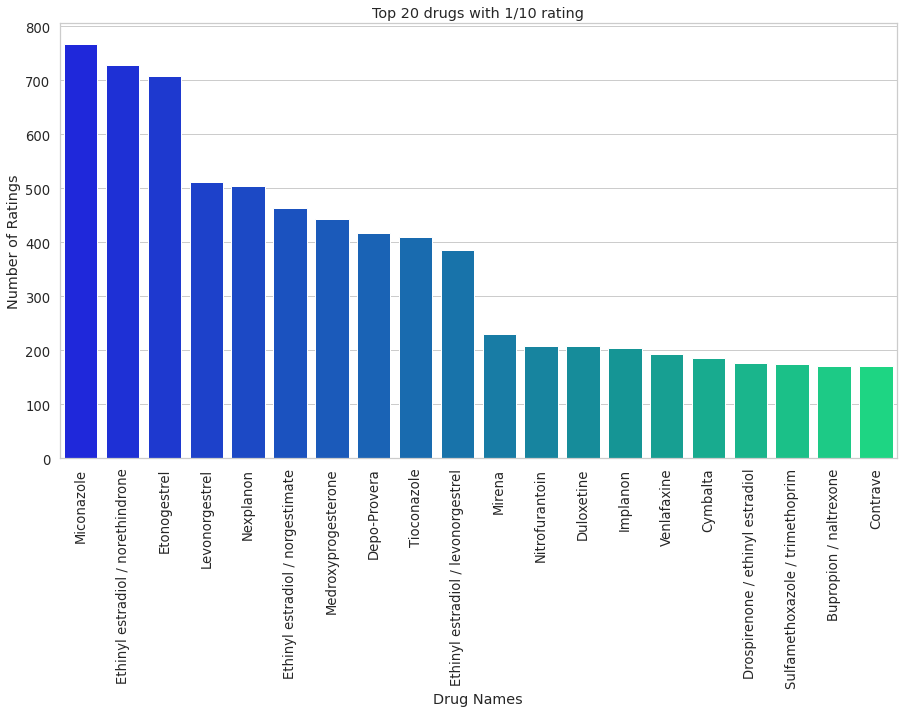

In [22]:
# This barplot shows the Top 20 drugs with the 1/10 rating

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df_data.loc[df_data.rating == 1, "drugname"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set(title = 'Top 20 drugs with 1/10 rating', ylabel = 'Number of Ratings', xlabel = "Drug Names")

plt.setp(sns_rating.get_xticklabels(), rotation=90);

Text(0.5, 0, 'Rating')

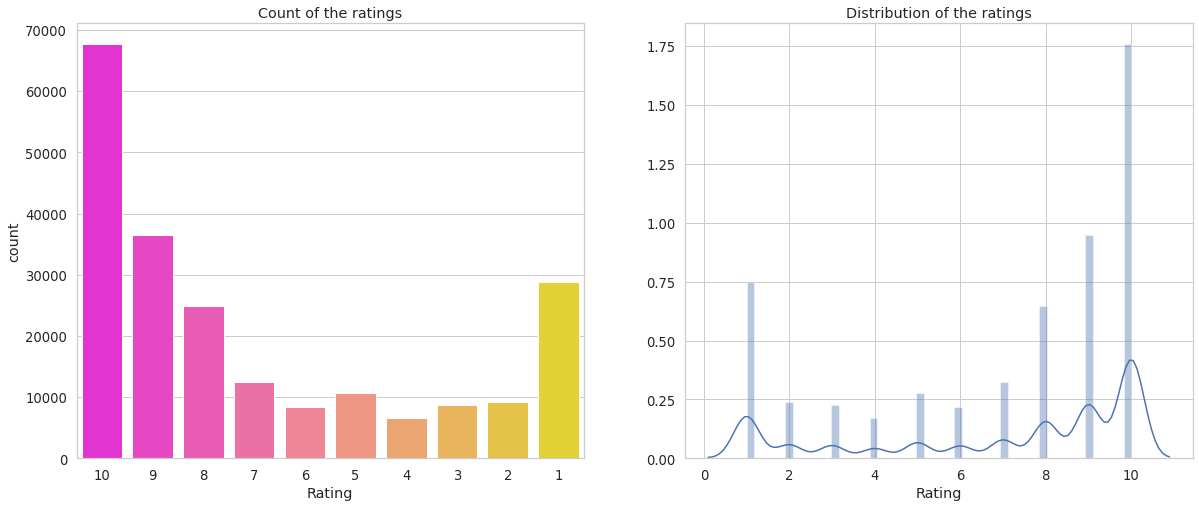

In [23]:
# A count plot to see the distribution of the ratings

plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.2, style='whitegrid')
fig, ax = plt.subplots(1,2)

sns_1 = sns.countplot(df_data['rating'], palette='spring', order=list(range(10,0,-1)), ax=ax[0])
sns_2 = sns.distplot(df_data['rating'], ax=ax[1])
sns_1.set_title("Count of the ratings")
sns_1.set_xlabel("Rating")

sns_2.set_title("Distribution of the ratings")
sns_2.set_xlabel("Rating")

(-0.5, 1199.5, 899.5, -0.5)

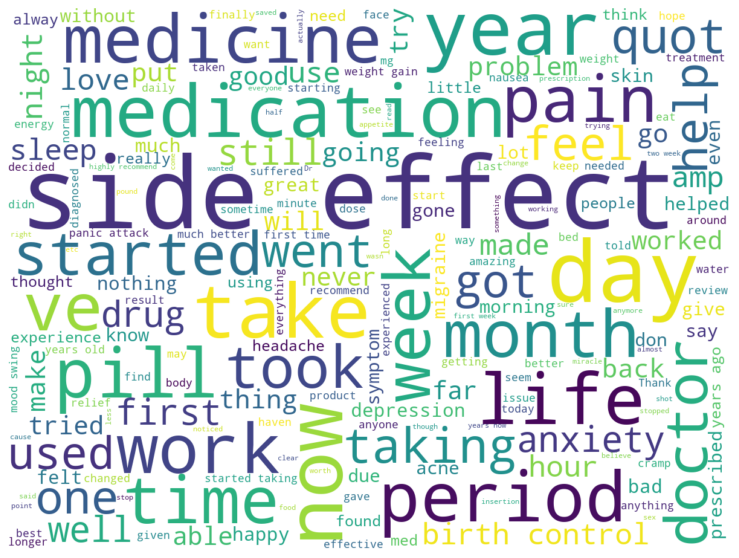

In [24]:
# Plotting word cloud of reviews with rating 10

top_rating = (' '.join(df_data.loc[df_data.rating == 10, 'review']))

wordcloud = WordCloud(width = 1200, height=900, background_color='white').generate(top_rating)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

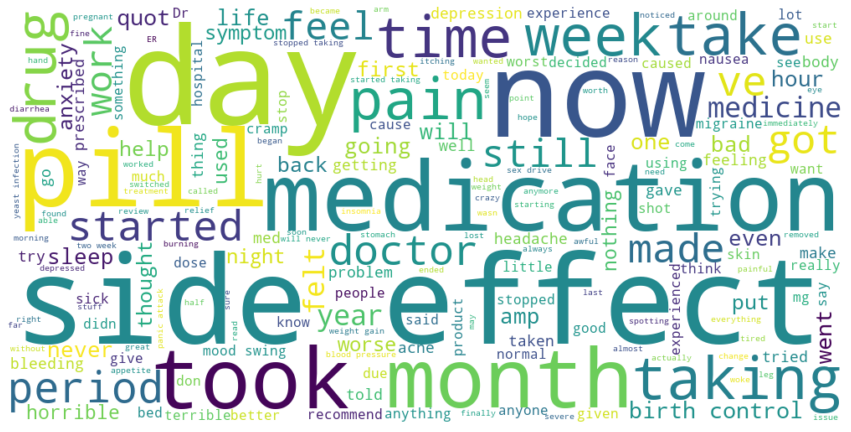

In [25]:
# Plotting word cloud of reviews with rating 1

top_rating = (' '.join(df_data.loc[df_data.rating == 1, 'review']))

wordcloud = WordCloud(width = 1000, height=500, background_color='white').generate(top_rating)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

Text(0, 0.5, 'Count')

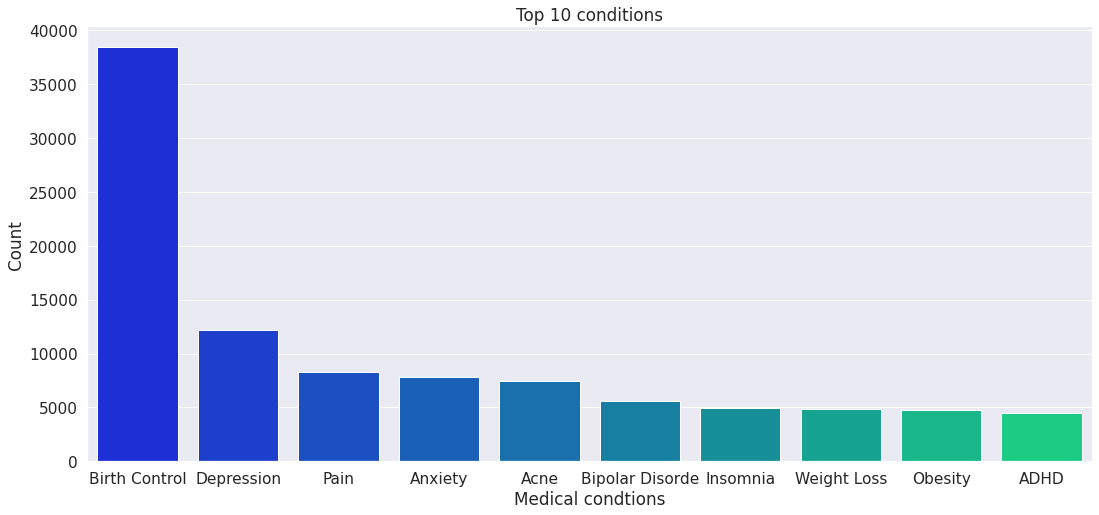

In [26]:
# Bar plot for top medical conditions

cond = dict(df_data['condition'].value_counts())
top_condition = list(cond.keys())[:10]
values = list(cond.values())[:10]

sns.set(style='darkgrid', font_scale=1.4)
plt.rcParams['figure.figsize'] = [18,8]

sns_top_cond = sns.barplot(x=top_condition, y=values, palette='winter')
sns_top_cond.set_title("Top 10 conditions")
sns_top_cond.set_xlabel("Medical condtions")
sns_top_cond.set_ylabel("Count")


Text(0, 0.5, 'Count')

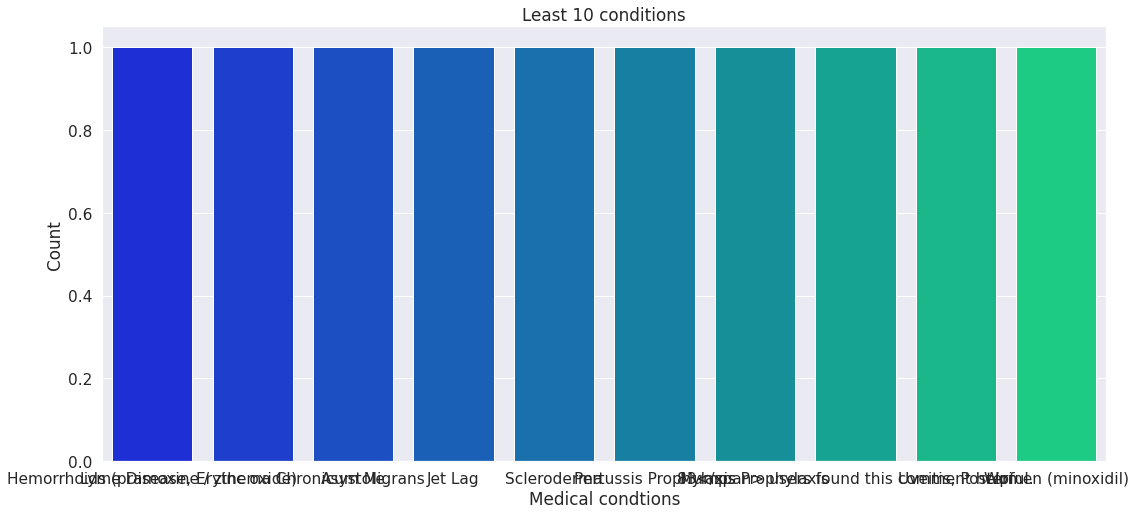

In [27]:
# Bar plot for least 10 medical conditions

cond = dict(df_data['condition'].value_counts())
top_condition = list(cond.keys())[-10:]
values = list(cond.values())[-10:]

sns.set(style='darkgrid', font_scale=1.4)
plt.rcParams['figure.figsize'] = [18,8]

sns_top_cond = sns.barplot(x=top_condition, y=values, palette='winter')
sns_top_cond.set_title("Least 10 conditions")
sns_top_cond.set_xlabel("Medical condtions")
sns_top_cond.set_ylabel("Count")

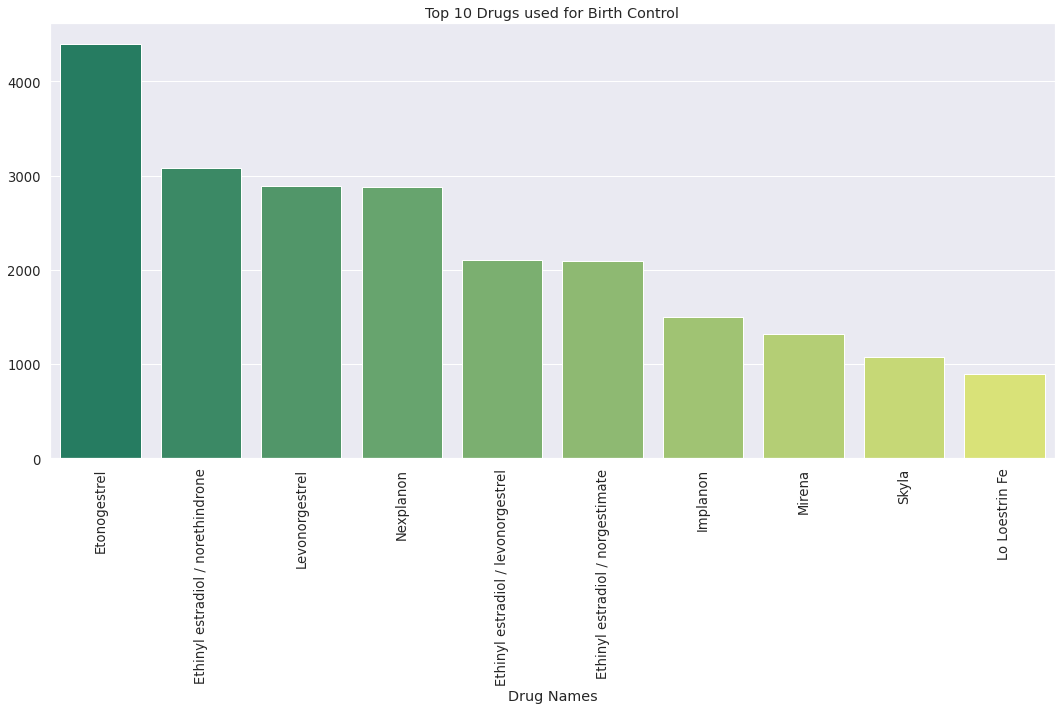

In [28]:
# Top 10 drugs which are used for the top condition, that is Birth Control

df = df_data[df_data['condition'] == 'Birth Control']['drugname'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df.index, y = df.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

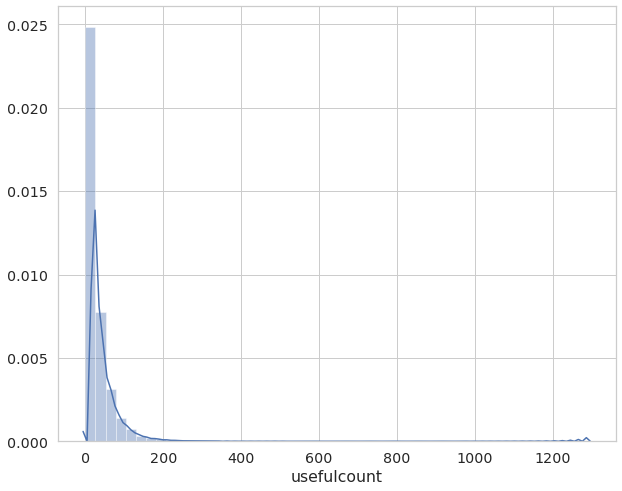

In [29]:
# Distribution of the useful count
sns.set(style='whitegrid', font_scale=1.3)
plt.rcParams['figure.figsize'] = [10,8]
sns.distplot(df_data['usefulcount'].dropna())

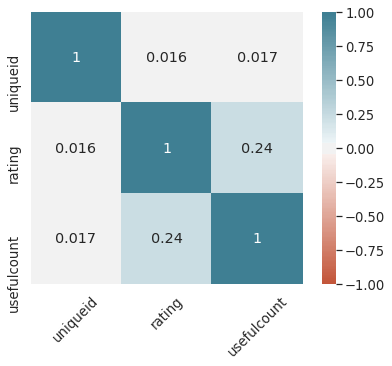

In [30]:
# Heatmap of the correlation matrix
plt.rcParams['figure.figsize'] = [7,5]
sns.set(font_scale = 1.2)
corr = df_data.select_dtypes(include = 'int64').corr()
sns_heat = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(20, 220, n=200), square=True);
plt.setp(sns_heat.get_xticklabels(), rotation = 45);

# n - grams

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


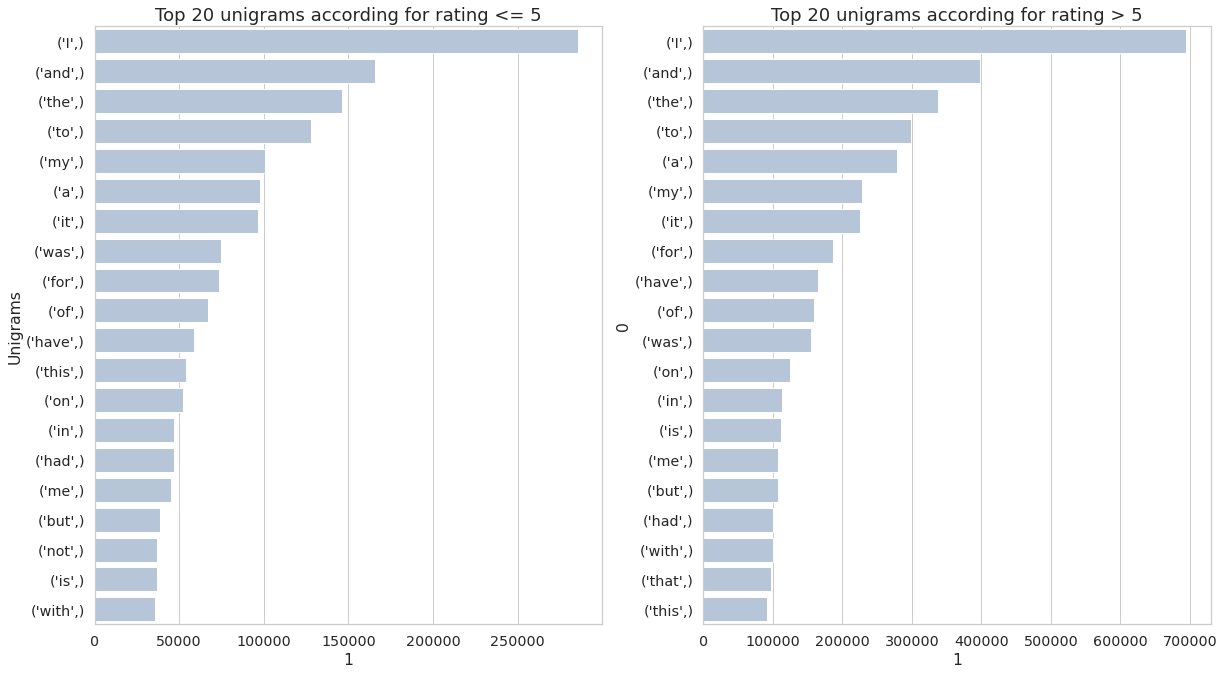

In [34]:
# Top 20 unigrams according to the rating
df_ = df_data[['rating', 'review']]
df_['review'] = df_data['review'].str.replace("&#039;", "")
df_['review'] = df_['review'].str.replace(r'[^\w\d\s]',' ')

df_review_5 = " ".join(df_.loc[df_.rating <= 5, 'review'])
df_review_10 = " ".join(df_.loc[df_.rating > 5, 'review'])

token_review_5 = word_tokenize(df_review_5)
token_review_10 = word_tokenize(df_review_10)

unigrams_5 = ngrams(token_review_5, 1)
unigrams_10 = ngrams(token_review_10, 1)

frequency_5 = Counter(unigrams_5)
frequency_10 = Counter(unigrams_10)

df_5 = pd.DataFrame(frequency_5.most_common(20))
df_10 = pd.DataFrame(frequency_10.most_common(20))

# Barplot that shows the top 20 unigrams
plt.rcParams['figure.figsize'] = [20,11]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.5, style = 'whitegrid')

sns_5 = sns.barplot(x = df_5[1], y = df_5[0], color = 'lightsteelblue', ax = ax[0])
sns_10 = sns.barplot(x = df_10[1], y = df_10[0], color = 'lightsteelblue', ax = ax[1])

# Setting axes labels
sns_5.set_title("Top 20 unigrams according for rating <= 5")
sns_10.set_title("Top 20 unigrams according for rating > 5")
sns_5.set_ylabel("Unigrams");


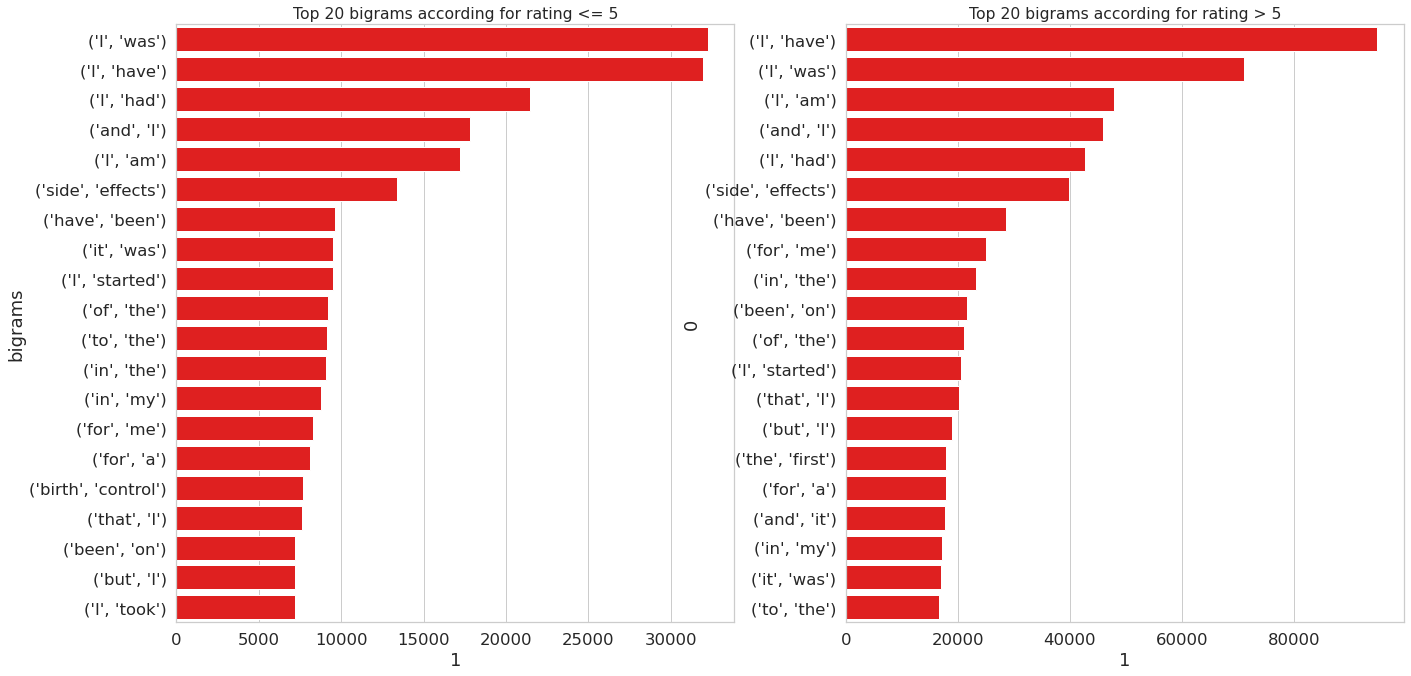

In [35]:
# Top 20 bigrams according to the rating
bigrams_5 = ngrams(token_review_5, 2)
bigrams_10 = ngrams(token_review_10, 2)

frequency_5 = Counter(bigrams_5)
frequency_10 = Counter(bigrams_10)

df_5 = pd.DataFrame(frequency_5.most_common(20))
df_10 = pd.DataFrame(frequency_10.most_common(20))

# Barplot that shows the top 20 bigrams
plt.rcParams['figure.figsize'] = [22,11]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.3, style = 'whitegrid')

sns_5 = sns.barplot(x = df_5[1], y = df_5[0], color = 'red', ax = ax[0])
sns_10 = sns.barplot(x = df_10[1], y = df_10[0], color = 'red', ax = ax[1])

# Setting axes labels
sns_5.set_title("Top 20 bigrams according for rating <= 5")
sns_10.set_title("Top 20 bigrams according for rating > 5")
sns_5.set_ylabel("bigrams");

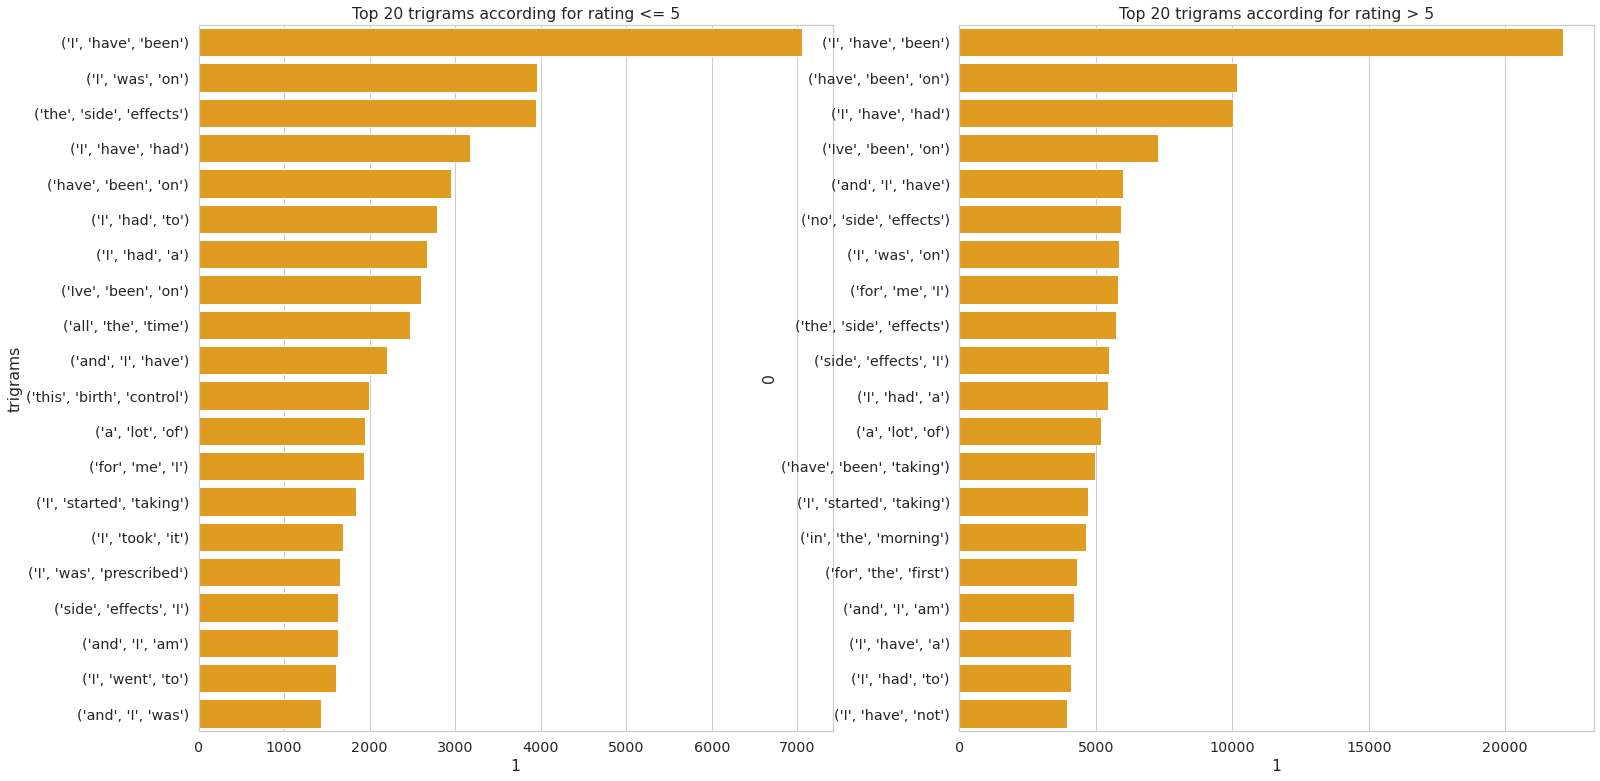

In [36]:
# Top 20 trigrams according to the rating
trigrams_5 = ngrams(token_review_5, 3)
trigrams_10 = ngrams(token_review_10, 3)

frequency_5 = Counter(trigrams_5)
frequency_10 = Counter(trigrams_10)

df_5 = pd.DataFrame(frequency_5.most_common(20))
df_10 = pd.DataFrame(frequency_10.most_common(20))

# Barplot that shows the top 20 trigrams
plt.rcParams['figure.figsize'] = [25,13]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.3, style = 'whitegrid')

sns_5 = sns.barplot(x = df_5[1], y = df_5[0], color = 'orange', ax = ax[0])
sns_10 = sns.barplot(x = df_10[1], y = df_10[0], color = 'orange', ax = ax[1])

# Setting axes labels
sns_5.set_title("Top 20 trigrams according for rating <= 5")
sns_10.set_title("Top 20 trigrams according for rating > 5")
sns_5.set_ylabel("trigrams");

# Word Count Plot and stopword removal

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


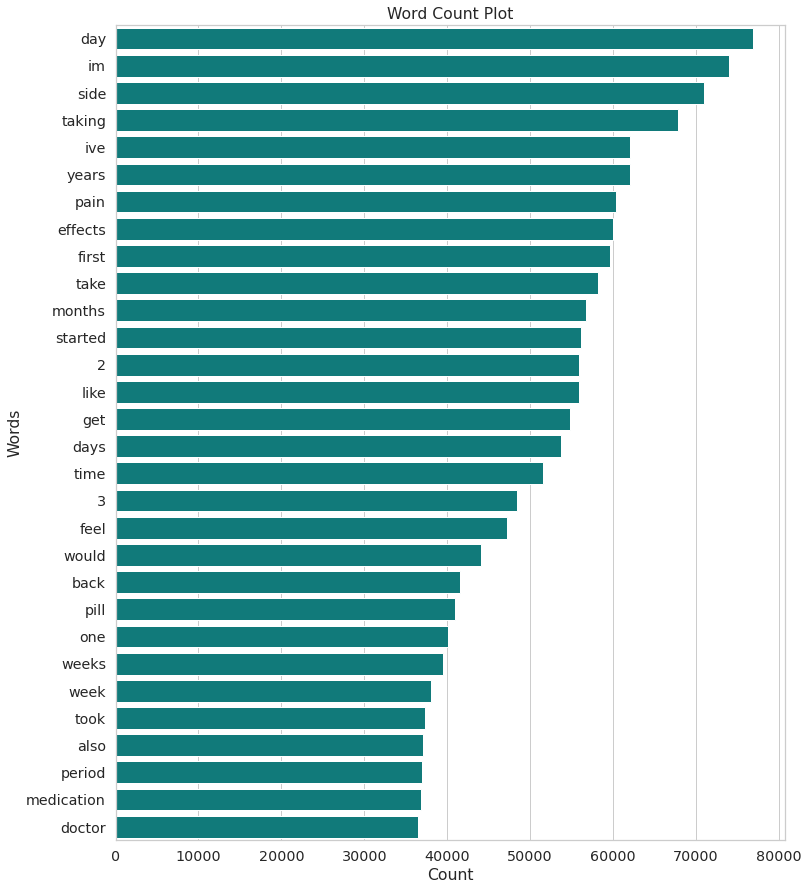

In [40]:
# Removing the stop words before plotting

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
df_['review'] = df_['review'].str.lower()
df_['review_1'] = df_['review'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
df_review = " ".join(df_['review_1'])
tokenize = word_tokenize(df_review)
frequency = Counter(tokenize)
df = pd.DataFrame(frequency.most_common(30))

plt.rcParams['figure.figsize'] = [12, 15]
sns.set(font_scale = 1.3, style = 'whitegrid')

# plotting
word_count = sns.barplot(x = df[1], y = df[0], color = 'darkcyan')
word_count.set_title("Word Count Plot")
word_count.set_ylabel("Words")
word_count.set_xlabel("Count");



# Preprocessing

We are going to use the threshold rating of 5 for giving the sentiment, The review will have a positive sentiment (1) if rating > 5 and negative sentiment otherwise.

In [41]:
# Giving the Sentiment according to the ratings
df_data['sentiment_rate'] = df_data['rating'].apply(lambda x: 1 if x > 5 else 0)

In [45]:
# Lets do some data cleaning now

def review_clean(review):
#     Changing to lower case
    lower = review.str.lower()

#     Replacing the repeating pattern of "&#039;"
    pattern_remove = lower.str.replace("&#039;", '')
    
#     Remove all special characters 
    speacial_remove = pattern_remove.replace(r'[^\w\d\s]', ' ')
    
#     Removing all non-ASCII characters
    ascii_remove = speacial_remove.replace(r'[^\x00-\x7F]+', ' ')
    
#     Removing the starting and trailing whitespaces
    whitespace_remove = ascii_remove.replace(r'^\s+|\s+?$', '')
    
#     Replacing multiple spaces with single space
    multiplw_remove = whitespace_remove.replace(r"\s+", ' ')
    
#     Replacing 2 or more dots with single one
    dataframe = multiplw_remove.replace(r"\.{2,}", ' ')
    
    return dataframe

In [46]:
# List of contractions for replacement

# Contraction Dictionary for the expansion

contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "doesn’t": "does not", "don't": "do not", "don’t": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
    "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not","might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not","sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y’all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "ain’t": "am not", "aren’t": "are not",
    "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have",
    "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
    "hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have",
    "he’s": "he is", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
    "i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have",
    "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
    "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
    "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock",
    "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have",
    "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "she’s": "she is",
    "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "so’s": "so is",
    "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would", "there’d’ve": "there would have",
    "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will", "they’ll’ve": "they will have",
    "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have",
    "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
    "what’ll’ve": "what will have", "what’re": "what are", "what’s": "what is", "what’ve": "what have", "when’s": "when is",
    "when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will",
    "who’ll’ve": "who will have", "who’s": "who is", "who’ve": "who have","why’s": "why is", "why’ve": "why have", "will’ve": "will have",
    "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have",
    "y’all": "you all", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are",
    "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
    "you’re": "you are", "you’re": "you are", "you’ve": "you have"
}

contractions_re = re.compile('(%s)' % '|' .join(contractions_dict.keys()))

# Expand the contractions if there are any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [47]:
# Calling the clean data function

df_data['review_clean'] = review_clean(df_data['review'])

# Expanding the contractions
df_data['review_clean'] = df_data['review_clean'].apply(lambda x: expand_contractions(x))

# Removing punctuations
df_data['review_clean'] = df_data['review_clean'].apply(lambda x:''.join(word for word in x if word not in punctuation))


In [48]:
df_data.head(10)

,uniqueid,drugname,condition,review,rating,date,usefulcount,sentiment_rate,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,0,been on the depo injection since january 2015 ...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,1,im 21 years old and recently found out i might...
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,1,i have been on the shot 11 years and until a m...
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,1,ive had four shots at this point i was on birt...
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,0,i had a total of 3 shots i got my first one be...
5,6,Medroxyprogesterone,Birth Control,"""This is a horrible shot!! I got my first shot...",1,2015-10-24,3,0,this is a horrible shot i got my first shot in...
6,7,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 18 and got this for heavy bleeding. ...",5,2015-10-22,6,0,im 18 and got this for heavy bleeding ive alwa...
7,8,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Im 19 and have been having heavy and painful ...",5,2015-10-21,2,0,im 19 and have been having heavy and painful p...
8,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,2015-10-21,5,0,im a 30 year old woman i got the shot on augus...
9,10,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 years old and I got shot in Augus...",7,2015-10-20,2,1,im 17 years old and i got shot in august 2015 ...


In [50]:
# removing the stopwords

df_data['review_clean'] = df_data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [51]:
# Removing the word stems using snowball stemmer
Snow_ball = SnowballStemmer("english")
df_data['review_clean'] = df_data['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))


In [52]:
df_data['review_clean'].head(20)

0     depo inject sinc januari 2015 bleed stop anoth...
1     im 21 year old recent found might pcos havent ...
2     shot 11 year month ago never 1 period even spo...
3     ive four shot point birth control pill year du...
4     total 3 shot got first one leav hospit give bi...
5     horribl shot got first shot august ever sinc e...
6     im 18 got heavi bleed ive alway heard bc make ...
7     im 19 heavi pain period sinc forev got depo sh...
8     im 30 year old woman got shot august 9th bleed...
9     im 17 year old got shot august 2015 person don...
10    first month awesom absolut wonder start light ...
11    start depo shot year ago origin bled 3 week da...
12    im 24 ive 2 year quit period last 3 week first...
13    im 17 went depo heavi bleed like heavi would g...
14    love conveni one shot everi three month look b...
15    1st shot sept 2nd nonstop bleed sinc side effe...
16    took shot safe im young teenag sexual activ bi...
17    ive shot 2 year amp one complaint skin cou

In [53]:
# Separating the day, month and year from the Date

df_data['day'] = df_data['date'].dt.day
df_data['month'] = df_data['date'].dt.month
df_data['year'] = df_data['date'].dt.year

In [54]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,sentiment_rate,review_clean,day,month,year
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,0,depo inject sinc januari 2015 bleed stop anoth...,28,10,2015
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,1,im 21 year old recent found might pcos havent ...,27,10,2015
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,1,shot 11 year month ago never 1 period even spo...,27,10,2015
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,1,ive four shot point birth control pill year du...,26,10,2015
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,0,total 3 shot got first one leav hospit give bi...,25,10,2015


In [55]:
def sentiment(review):
    # Sentiment polarity of the reviews
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

In [56]:
df_data['sentiment'] = sentiment(df_data['review'])

In [57]:
df_data['sentiment_clean'] = sentiment(df_data['review_clean'])

In [58]:
np.corrcoef(df_data['sentiment'], df_data['rating'])

array([[1.       , 0.3481753],
       [0.3481753, 1.       ]])

In [59]:
np.corrcoef(df_data['sentiment_clean'], df_data['rating'])

array([[1.        , 0.23255017],
       [0.23255017, 1.        ]])

In [62]:
# Cleaning the reviews without removing the stop words and using snowball stemmer

df_data['review_clean_ss'] = review_clean(df_data['review'])

df_data['review_clean_ss'] = df_data['review_clean_ss'].apply(lambda x: expand_contractions(x))

df_data['review_clean_ss'] = df_data['review_clean_ss'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

df_data['sentiment_clean_ss'] = sentiment(df_data['review_clean_ss'])

In [63]:
np.corrcoef(df_data['sentiment_clean_ss'], df_data['rating'])

array([[1.        , 0.34479332],
       [0.34479332, 1.        ]])

Printing data now

In [61]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,sentiment_rate,review_clean,day,month,year,sentiment,sentiment_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,0,depo inject sinc januari 2015 bleed stop anoth...,28,10,2015,-0.287798,-0.152857
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,1,im 21 year old recent found might pcos havent ...,27,10,2015,0.175357,0.161429
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,1,shot 11 year month ago never 1 period even spo...,27,10,2015,-0.210000,0.233333
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,1,ive four shot point birth control pill year du...,26,10,2015,-0.022500,0.069444
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,0,total 3 shot got first one leav hospit give bi...,25,10,2015,0.044872,0.103333


## Feature Engineering

In [64]:
# Word count in each review
df_data['count_word'] = df_data['review_clean_ss'].apply(lambda x:len(str(x).split()))

# Unique word count
df_data['count_unique_word'] = df_data['review_clean_ss'].apply(lambda x:len(set(str(x).split())))

# Letter count
df_data['count_letters'] = df_data['review_clean_ss'].apply(lambda x: len(str(x)))

# Punctuation count
df_data['count_punctuations'] = df_data['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Upper case word count
df_data['count_words_upper'] = df_data['review'].apply(lambda x:len([w for w in str(x).split() if w.isupper()]))

# title case word count
df_data['count_words_title'] = df_data['review'].apply(lambda x:len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
df_data['count_stopwords'] = df_data['review'].apply(lambda x:len([w for w in str(x).lower() if w in stop_words]))

# Average word length
df_data['mean_word_length'] = df_data['review_clean_ss'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [65]:
df_data.columns

Index(['uniqueid', 'drugname', 'condition', 'review', 'rating', 'date',
       'usefulcount', 'sentiment_rate', 'review_clean', 'day', 'month', 'year',
       'sentiment', 'sentiment_clean', 'review_clean_ss', 'sentiment_clean_ss',
       'count_word', 'count_unique_word', 'count_letters',
       'count_punctuations', 'count_words_upper', 'count_words_title',
       'count_stopwords', 'mean_word_length'],
      dtype='object')

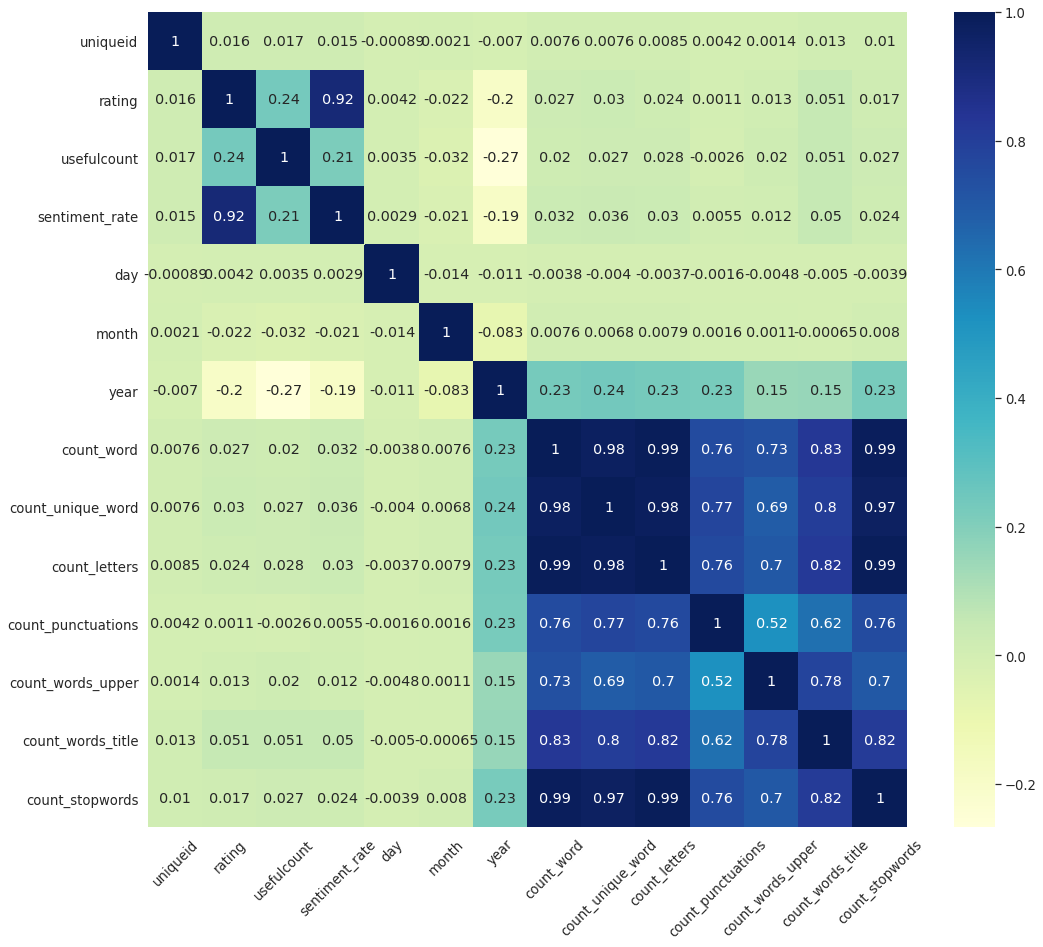

In [67]:
# Correlation Heatmap of the features engineered
plt.rcParams['figure.figsize'] = [17,15]
sns.set(font_scale = 1.2)
corr = df_data.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
plt.setp(sns_.get_xticklabels(), rotation = 45);

       


In [69]:
# Label Encoding Drugname and Conditions
label_encoder_feat = {}
for feature in ['drugname', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    df_data[feature] = label_encoder_feat[feature].fit_transform(df_data[feature])

# Modelling

In [70]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,sentiment_rate,review_clean,day,...,review_clean_ss,sentiment_clean_ss,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_length
0,0,2043,84,"""Been on the depo injection since January 2015...",3,2015-10-28,4,0,depo inject sinc januari 2015 bleed stop anoth...,28,...,been on the depo injection since january 2015 ...,-0.192857,99,74,542,31,6,14,200,4.474747
1,2,2043,110,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,1,im 21 year old recent found might pcos havent ...,27,...,im 21 years old and recently found out i might...,0.175357,103,76,548,26,5,13,213,4.320388
2,3,2043,84,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,1,shot 11 year month ago never 1 period even spo...,27,...,i have been on the shot 11 years and until a m...,-0.210000,59,45,282,12,4,5,101,3.745763
3,4,2043,175,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,1,ive four shot point birth control pill year du...,26,...,ive had four shots at this point i was on birt...,-0.033333,143,92,729,21,4,12,282,4.104895
4,5,2043,84,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,0,total 3 shot got first one leav hospit give bi...,25,...,i had a total of 3 shots i got my first one be...,0.044872,152,102,728,21,13,20,292,3.796053


In [73]:
# Defining Features and splitting the data as train and test set

features = df_data[['condition', 'usefulcount', 'sentiment', 'day', 'month', 'year',
                   'sentiment_clean_ss', 'count_word', 'count_unique_word', 'count_letters',
                   'count_punctuations', 'count_words_upper', 'count_words_title',
                   'count_stopwords', 'mean_word_length']]

target = df_data['sentiment_rate']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (149708, 15)
The Test set size  (64161, 15)


# Model 1- LightGBM

In [74]:
# Training Model - 1

clf = LGBMClassifier(
    
    n_estimators=10000,
    learning_rate=0.10,
    num_leaves=30,
    subsample=0.9,
    max_depth=7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_split_gain=0.01,
    min_child_weight=2,
    silent=-1,
    verbose=-1,
    
    )

model = clf.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

print("The accuracy of the model is: ", accuracy_score(y_test, predictions), '\n')
print('The confusion matrix is \n')
print(confusion_matrix(y_test, predictions), '\n')

print(classification_report(y_test, predictions))


The accuracy of the model is:  0.8895279063605617 

The confusion matrix is 

[[14815  4530]
 [ 2558 42258]] 

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     19345
           1       0.90      0.94      0.92     44816

    accuracy                           0.89     64161
   macro avg       0.88      0.85      0.86     64161
weighted avg       0.89      0.89      0.89     64161



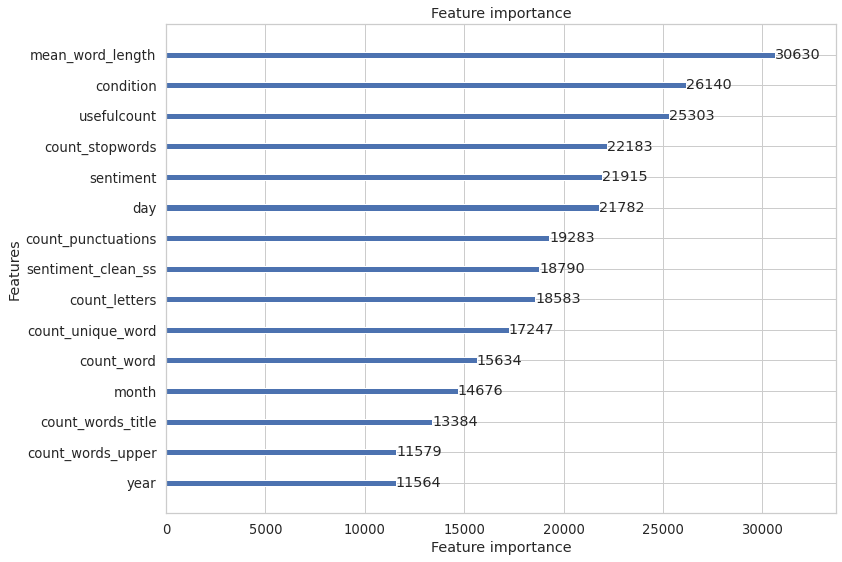

In [75]:
# Feature Importance Plot using LGBM
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style = 'whitegrid', font_scale = 1.2)
plot_importance(model);

# Model - II XGBClassifier

In [76]:
# Training Model - II

xgb_clf = XGBClassifier(n_estimator = 10000,
                        learning_rate = 0.1,
                        num_leaves = 30)
model_xgb = xgb_clf.fit(X_train, y_train)

# Predictions using XGBoost algo

predictions_2 = model_xgb.predict(X_test)

print("Accuracy of the model is - ", accuracy_score(y_test, predictions_2, '\n'))
print("Confusin matrix - ")
print(confusion_matrix(y_test, predictions_2), '\n')

print(classification_report(y_test, predictions_2))

[15:12:11] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimator, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass normalize=
 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Accuracy of the model is -  0.7685198173345179
Confusin matrix - 
[[ 8155 11190]
 [ 3662 41154]] 

              precision    recall  f1-score   support

           0       0.69      0.42      0.52     19345
           1       0.79      0.92      0.85     44816

    accuracy                           0.77     64161
   macro avg       0.74      0.67      0.69     64161
weighted avg       0.76      0.77      0.75     64161



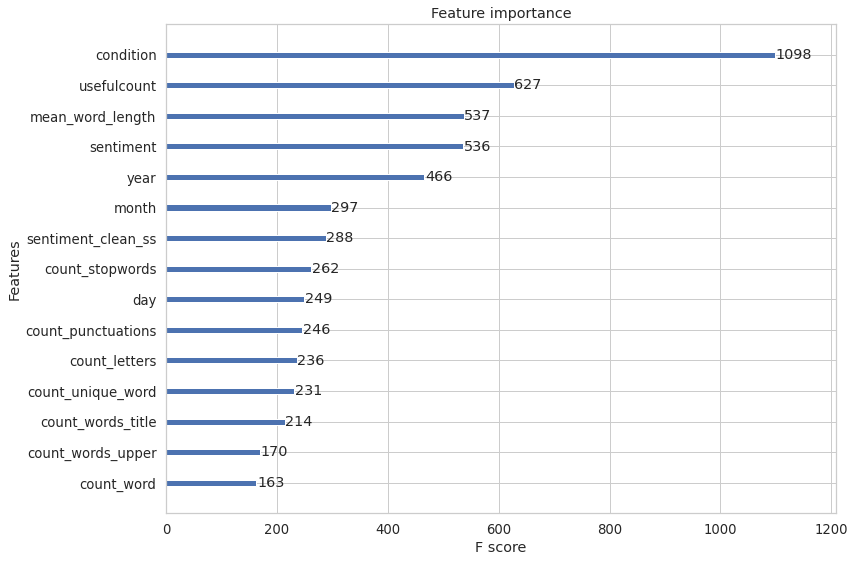

In [77]:
# Feature Importance Plot using XGBClassifier
from xgboost import plot_importance # plot_importance for xgboost
plt.rcParams['figure.figsize'] = [12, 9]
plot_importance(model_xgb);

# Model - III CatBoostClassifier

In [78]:
# Training Model - III

cat_clf = CatBoostClassifier(iterations = 10000,
                            learning_rate = 0.5);

model_cat = cat_clf.fit(X_train, y_train);

0:	learn: 0.5596718	total: 103ms	remaining: 17m 12s
1:	learn: 0.5272041	total: 140ms	remaining: 11m 37s
2:	learn: 0.5170627	total: 175ms	remaining: 9m 42s
3:	learn: 0.5105736	total: 217ms	remaining: 9m 1s
4:	learn: 0.5077498	total: 263ms	remaining: 8m 45s
5:	learn: 0.5038876	total: 326ms	remaining: 9m 2s
6:	learn: 0.5023965	total: 394ms	remaining: 9m 23s
7:	learn: 0.5002084	total: 454ms	remaining: 9m 26s
8:	learn: 0.4990861	total: 526ms	remaining: 9m 43s
9:	learn: 0.4980882	total: 608ms	remaining: 10m 7s
10:	learn: 0.4971297	total: 697ms	remaining: 10m 33s
11:	learn: 0.4962049	total: 758ms	remaining: 10m 30s
12:	learn: 0.4955178	total: 813ms	remaining: 10m 24s
13:	learn: 0.4943979	total: 874ms	remaining: 10m 23s
14:	learn: 0.4937707	total: 927ms	remaining: 10m 17s
15:	learn: 0.4929765	total: 983ms	remaining: 10m 13s
16:	learn: 0.4923720	total: 1.04s	remaining: 10m 12s
17:	learn: 0.4909044	total: 1.1s	remaining: 10m 10s
18:	learn: 0.4903967	total: 1.16s	remaining: 10m 7s
19:	learn: 0.48

159:	learn: 0.4359539	total: 6.73s	remaining: 6m 54s
160:	learn: 0.4357405	total: 6.77s	remaining: 6m 53s
161:	learn: 0.4353877	total: 6.81s	remaining: 6m 53s
162:	learn: 0.4352150	total: 6.85s	remaining: 6m 53s
163:	learn: 0.4350797	total: 6.89s	remaining: 6m 53s
164:	learn: 0.4348213	total: 6.92s	remaining: 6m 52s
165:	learn: 0.4344485	total: 6.96s	remaining: 6m 52s
166:	learn: 0.4341532	total: 7s	remaining: 6m 52s
167:	learn: 0.4339343	total: 7.04s	remaining: 6m 51s
168:	learn: 0.4335776	total: 7.08s	remaining: 6m 51s
169:	learn: 0.4333560	total: 7.12s	remaining: 6m 51s
170:	learn: 0.4330324	total: 7.16s	remaining: 6m 51s
171:	learn: 0.4327256	total: 7.2s	remaining: 6m 51s
172:	learn: 0.4323644	total: 7.24s	remaining: 6m 51s
173:	learn: 0.4321259	total: 7.28s	remaining: 6m 51s
174:	learn: 0.4318818	total: 7.32s	remaining: 6m 50s
175:	learn: 0.4316461	total: 7.36s	remaining: 6m 50s
176:	learn: 0.4313422	total: 7.4s	remaining: 6m 50s
177:	learn: 0.4311118	total: 7.44s	remaining: 6m 50

315:	learn: 0.3985922	total: 13s	remaining: 6m 36s
316:	learn: 0.3983749	total: 13s	remaining: 6m 36s
317:	learn: 0.3980843	total: 13s	remaining: 6m 36s
318:	learn: 0.3978247	total: 13.1s	remaining: 6m 36s
319:	learn: 0.3975722	total: 13.1s	remaining: 6m 36s
320:	learn: 0.3973847	total: 13.2s	remaining: 6m 36s
321:	learn: 0.3971097	total: 13.2s	remaining: 6m 36s
322:	learn: 0.3969125	total: 13.2s	remaining: 6m 36s
323:	learn: 0.3966638	total: 13.3s	remaining: 6m 36s
324:	learn: 0.3964357	total: 13.3s	remaining: 6m 36s
325:	learn: 0.3961544	total: 13.4s	remaining: 6m 36s
326:	learn: 0.3958853	total: 13.4s	remaining: 6m 36s
327:	learn: 0.3956792	total: 13.4s	remaining: 6m 36s
328:	learn: 0.3953860	total: 13.5s	remaining: 6m 36s
329:	learn: 0.3951799	total: 13.5s	remaining: 6m 35s
330:	learn: 0.3949517	total: 13.6s	remaining: 6m 35s
331:	learn: 0.3947279	total: 13.6s	remaining: 6m 35s
332:	learn: 0.3945313	total: 13.6s	remaining: 6m 35s
333:	learn: 0.3942795	total: 13.7s	remaining: 6m 35s

473:	learn: 0.3652564	total: 19.2s	remaining: 6m 25s
474:	learn: 0.3651486	total: 19.2s	remaining: 6m 25s
475:	learn: 0.3649813	total: 19.3s	remaining: 6m 25s
476:	learn: 0.3647825	total: 19.3s	remaining: 6m 25s
477:	learn: 0.3645353	total: 19.3s	remaining: 6m 25s
478:	learn: 0.3643731	total: 19.4s	remaining: 6m 25s
479:	learn: 0.3642264	total: 19.4s	remaining: 6m 25s
480:	learn: 0.3641961	total: 19.5s	remaining: 6m 25s
481:	learn: 0.3641008	total: 19.5s	remaining: 6m 24s
482:	learn: 0.3638859	total: 19.5s	remaining: 6m 24s
483:	learn: 0.3636925	total: 19.6s	remaining: 6m 24s
484:	learn: 0.3635580	total: 19.6s	remaining: 6m 24s
485:	learn: 0.3634077	total: 19.7s	remaining: 6m 24s
486:	learn: 0.3632466	total: 19.7s	remaining: 6m 24s
487:	learn: 0.3630510	total: 19.7s	remaining: 6m 24s
488:	learn: 0.3627760	total: 19.8s	remaining: 6m 24s
489:	learn: 0.3626085	total: 19.8s	remaining: 6m 24s
490:	learn: 0.3623820	total: 19.9s	remaining: 6m 24s
491:	learn: 0.3621629	total: 19.9s	remaining: 

629:	learn: 0.3375232	total: 25.4s	remaining: 6m 17s
630:	learn: 0.3373605	total: 25.5s	remaining: 6m 17s
631:	learn: 0.3372497	total: 25.5s	remaining: 6m 17s
632:	learn: 0.3371134	total: 25.5s	remaining: 6m 17s
633:	learn: 0.3369741	total: 25.6s	remaining: 6m 17s
634:	learn: 0.3368717	total: 25.6s	remaining: 6m 17s
635:	learn: 0.3367404	total: 25.6s	remaining: 6m 17s
636:	learn: 0.3365710	total: 25.7s	remaining: 6m 17s
637:	learn: 0.3363934	total: 25.7s	remaining: 6m 17s
638:	learn: 0.3362701	total: 25.8s	remaining: 6m 17s
639:	learn: 0.3360651	total: 25.8s	remaining: 6m 17s
640:	learn: 0.3358191	total: 25.8s	remaining: 6m 17s
641:	learn: 0.3355596	total: 25.9s	remaining: 6m 17s
642:	learn: 0.3353695	total: 25.9s	remaining: 6m 17s
643:	learn: 0.3351746	total: 26s	remaining: 6m 17s
644:	learn: 0.3350249	total: 26s	remaining: 6m 17s
645:	learn: 0.3347786	total: 26s	remaining: 6m 16s
646:	learn: 0.3346115	total: 26.1s	remaining: 6m 16s
647:	learn: 0.3344739	total: 26.1s	remaining: 6m 16s

788:	learn: 0.3118350	total: 31.7s	remaining: 6m 10s
789:	learn: 0.3116314	total: 31.8s	remaining: 6m 10s
790:	learn: 0.3114712	total: 31.8s	remaining: 6m 10s
791:	learn: 0.3112509	total: 31.9s	remaining: 6m 10s
792:	learn: 0.3111131	total: 31.9s	remaining: 6m 10s
793:	learn: 0.3109813	total: 32s	remaining: 6m 11s
794:	learn: 0.3108011	total: 32.1s	remaining: 6m 11s
795:	learn: 0.3105605	total: 32.1s	remaining: 6m 11s
796:	learn: 0.3104309	total: 32.2s	remaining: 6m 11s
797:	learn: 0.3102748	total: 32.3s	remaining: 6m 11s
798:	learn: 0.3100188	total: 32.3s	remaining: 6m 12s
799:	learn: 0.3098994	total: 32.4s	remaining: 6m 12s
800:	learn: 0.3097161	total: 32.4s	remaining: 6m 12s
801:	learn: 0.3096004	total: 32.5s	remaining: 6m 12s
802:	learn: 0.3093648	total: 32.5s	remaining: 6m 12s
803:	learn: 0.3091949	total: 32.6s	remaining: 6m 12s
804:	learn: 0.3090739	total: 32.7s	remaining: 6m 13s
805:	learn: 0.3088934	total: 32.7s	remaining: 6m 13s
806:	learn: 0.3086924	total: 32.8s	remaining: 6m

948:	learn: 0.2882832	total: 39s	remaining: 6m 12s
949:	learn: 0.2881491	total: 39.1s	remaining: 6m 12s
950:	learn: 0.2880185	total: 39.1s	remaining: 6m 11s
951:	learn: 0.2879022	total: 39.1s	remaining: 6m 11s
952:	learn: 0.2877664	total: 39.2s	remaining: 6m 11s
953:	learn: 0.2876161	total: 39.2s	remaining: 6m 11s
954:	learn: 0.2874536	total: 39.3s	remaining: 6m 11s
955:	learn: 0.2872678	total: 39.3s	remaining: 6m 11s
956:	learn: 0.2871865	total: 39.3s	remaining: 6m 11s
957:	learn: 0.2870143	total: 39.4s	remaining: 6m 11s
958:	learn: 0.2868981	total: 39.4s	remaining: 6m 11s
959:	learn: 0.2868067	total: 39.5s	remaining: 6m 11s
960:	learn: 0.2866551	total: 39.5s	remaining: 6m 11s
961:	learn: 0.2865214	total: 39.5s	remaining: 6m 11s
962:	learn: 0.2864130	total: 39.6s	remaining: 6m 11s
963:	learn: 0.2863516	total: 39.6s	remaining: 6m 11s
964:	learn: 0.2862368	total: 39.7s	remaining: 6m 11s
965:	learn: 0.2860897	total: 39.7s	remaining: 6m 11s
966:	learn: 0.2859877	total: 39.7s	remaining: 6m

1106:	learn: 0.2674649	total: 45.6s	remaining: 6m 6s
1107:	learn: 0.2673118	total: 45.6s	remaining: 6m 6s
1108:	learn: 0.2672014	total: 45.7s	remaining: 6m 6s
1109:	learn: 0.2670965	total: 45.7s	remaining: 6m 6s
1110:	learn: 0.2669643	total: 45.8s	remaining: 6m 6s
1111:	learn: 0.2669056	total: 45.8s	remaining: 6m 6s
1112:	learn: 0.2668474	total: 45.8s	remaining: 6m 6s
1113:	learn: 0.2667285	total: 45.9s	remaining: 6m 5s
1114:	learn: 0.2666086	total: 45.9s	remaining: 6m 5s
1115:	learn: 0.2664984	total: 46s	remaining: 6m 5s
1116:	learn: 0.2663506	total: 46s	remaining: 6m 5s
1117:	learn: 0.2661421	total: 46s	remaining: 6m 5s
1118:	learn: 0.2660482	total: 46.1s	remaining: 6m 5s
1119:	learn: 0.2659370	total: 46.1s	remaining: 6m 5s
1120:	learn: 0.2657886	total: 46.2s	remaining: 6m 5s
1121:	learn: 0.2656707	total: 46.2s	remaining: 6m 5s
1122:	learn: 0.2655533	total: 46.2s	remaining: 6m 5s
1123:	learn: 0.2654095	total: 46.3s	remaining: 6m 5s
1124:	learn: 0.2653065	total: 46.3s	remaining: 6m 5s

1265:	learn: 0.2490351	total: 51.9s	remaining: 5m 58s
1266:	learn: 0.2489633	total: 51.9s	remaining: 5m 57s
1267:	learn: 0.2488235	total: 52s	remaining: 5m 57s
1268:	learn: 0.2486934	total: 52s	remaining: 5m 57s
1269:	learn: 0.2485462	total: 52.1s	remaining: 5m 57s
1270:	learn: 0.2484127	total: 52.1s	remaining: 5m 57s
1271:	learn: 0.2483372	total: 52.1s	remaining: 5m 57s
1272:	learn: 0.2482480	total: 52.2s	remaining: 5m 57s
1273:	learn: 0.2480933	total: 52.2s	remaining: 5m 57s
1274:	learn: 0.2479303	total: 52.3s	remaining: 5m 57s
1275:	learn: 0.2478536	total: 52.3s	remaining: 5m 57s
1276:	learn: 0.2477704	total: 52.3s	remaining: 5m 57s
1277:	learn: 0.2476079	total: 52.4s	remaining: 5m 57s
1278:	learn: 0.2475001	total: 52.4s	remaining: 5m 57s
1279:	learn: 0.2473434	total: 52.5s	remaining: 5m 57s
1280:	learn: 0.2472694	total: 52.5s	remaining: 5m 57s
1281:	learn: 0.2471278	total: 52.5s	remaining: 5m 57s
1282:	learn: 0.2470236	total: 52.6s	remaining: 5m 57s
1283:	learn: 0.2469387	total: 52

1423:	learn: 0.2316017	total: 58.3s	remaining: 5m 50s
1424:	learn: 0.2315110	total: 58.3s	remaining: 5m 50s
1425:	learn: 0.2314053	total: 58.3s	remaining: 5m 50s
1426:	learn: 0.2312953	total: 58.4s	remaining: 5m 50s
1427:	learn: 0.2311877	total: 58.4s	remaining: 5m 50s
1428:	learn: 0.2310562	total: 58.4s	remaining: 5m 50s
1429:	learn: 0.2309637	total: 58.5s	remaining: 5m 50s
1430:	learn: 0.2308848	total: 58.5s	remaining: 5m 50s
1431:	learn: 0.2307653	total: 58.6s	remaining: 5m 50s
1432:	learn: 0.2306495	total: 58.6s	remaining: 5m 50s
1433:	learn: 0.2305291	total: 58.6s	remaining: 5m 50s
1434:	learn: 0.2304137	total: 58.7s	remaining: 5m 50s
1435:	learn: 0.2303370	total: 58.7s	remaining: 5m 50s
1436:	learn: 0.2302425	total: 58.8s	remaining: 5m 50s
1437:	learn: 0.2301146	total: 58.8s	remaining: 5m 50s
1438:	learn: 0.2299766	total: 58.8s	remaining: 5m 50s
1439:	learn: 0.2299269	total: 58.9s	remaining: 5m 50s
1440:	learn: 0.2298060	total: 58.9s	remaining: 5m 49s
1441:	learn: 0.2297408	total

1580:	learn: 0.2159756	total: 1m 4s	remaining: 5m 45s
1581:	learn: 0.2158889	total: 1m 4s	remaining: 5m 45s
1582:	learn: 0.2157732	total: 1m 5s	remaining: 5m 45s
1583:	learn: 0.2156287	total: 1m 5s	remaining: 5m 45s
1584:	learn: 0.2155547	total: 1m 5s	remaining: 5m 45s
1585:	learn: 0.2154757	total: 1m 5s	remaining: 5m 45s
1586:	learn: 0.2153958	total: 1m 5s	remaining: 5m 45s
1587:	learn: 0.2152891	total: 1m 5s	remaining: 5m 45s
1588:	learn: 0.2151583	total: 1m 5s	remaining: 5m 45s
1589:	learn: 0.2150736	total: 1m 5s	remaining: 5m 45s
1590:	learn: 0.2149537	total: 1m 5s	remaining: 5m 45s
1591:	learn: 0.2148890	total: 1m 5s	remaining: 5m 45s
1592:	learn: 0.2147778	total: 1m 5s	remaining: 5m 45s
1593:	learn: 0.2146345	total: 1m 5s	remaining: 5m 45s
1594:	learn: 0.2144774	total: 1m 5s	remaining: 5m 45s
1595:	learn: 0.2143606	total: 1m 5s	remaining: 5m 45s
1596:	learn: 0.2142523	total: 1m 5s	remaining: 5m 45s
1597:	learn: 0.2141037	total: 1m 5s	remaining: 5m 45s
1598:	learn: 0.2139960	total

1736:	learn: 0.2012801	total: 1m 11s	remaining: 5m 39s
1737:	learn: 0.2011679	total: 1m 11s	remaining: 5m 39s
1738:	learn: 0.2011208	total: 1m 11s	remaining: 5m 39s
1739:	learn: 0.2010432	total: 1m 11s	remaining: 5m 39s
1740:	learn: 0.2009608	total: 1m 11s	remaining: 5m 39s
1741:	learn: 0.2008436	total: 1m 11s	remaining: 5m 39s
1742:	learn: 0.2007524	total: 1m 11s	remaining: 5m 39s
1743:	learn: 0.2007193	total: 1m 11s	remaining: 5m 39s
1744:	learn: 0.2006242	total: 1m 11s	remaining: 5m 39s
1745:	learn: 0.2005927	total: 1m 11s	remaining: 5m 39s
1746:	learn: 0.2005312	total: 1m 11s	remaining: 5m 39s
1747:	learn: 0.2004039	total: 1m 11s	remaining: 5m 39s
1748:	learn: 0.2003323	total: 1m 11s	remaining: 5m 39s
1749:	learn: 0.2002363	total: 1m 11s	remaining: 5m 39s
1750:	learn: 0.2001242	total: 1m 11s	remaining: 5m 38s
1751:	learn: 0.2000090	total: 1m 11s	remaining: 5m 38s
1752:	learn: 0.1999259	total: 1m 12s	remaining: 5m 38s
1753:	learn: 0.1998292	total: 1m 12s	remaining: 5m 38s
1754:	lear

1886:	learn: 0.1878514	total: 1m 17s	remaining: 5m 33s
1887:	learn: 0.1877941	total: 1m 17s	remaining: 5m 33s
1888:	learn: 0.1877308	total: 1m 17s	remaining: 5m 33s
1889:	learn: 0.1876562	total: 1m 17s	remaining: 5m 33s
1890:	learn: 0.1875601	total: 1m 17s	remaining: 5m 33s
1891:	learn: 0.1874837	total: 1m 17s	remaining: 5m 32s
1892:	learn: 0.1874114	total: 1m 17s	remaining: 5m 32s
1893:	learn: 0.1873567	total: 1m 17s	remaining: 5m 32s
1894:	learn: 0.1873264	total: 1m 17s	remaining: 5m 32s
1895:	learn: 0.1872593	total: 1m 17s	remaining: 5m 32s
1896:	learn: 0.1871897	total: 1m 17s	remaining: 5m 32s
1897:	learn: 0.1871178	total: 1m 17s	remaining: 5m 32s
1898:	learn: 0.1870204	total: 1m 17s	remaining: 5m 32s
1899:	learn: 0.1869579	total: 1m 18s	remaining: 5m 32s
1900:	learn: 0.1868618	total: 1m 18s	remaining: 5m 32s
1901:	learn: 0.1867636	total: 1m 18s	remaining: 5m 32s
1902:	learn: 0.1866742	total: 1m 18s	remaining: 5m 32s
1903:	learn: 0.1865409	total: 1m 18s	remaining: 5m 32s
1904:	lear

2035:	learn: 0.1765467	total: 1m 23s	remaining: 5m 26s
2036:	learn: 0.1764438	total: 1m 23s	remaining: 5m 26s
2037:	learn: 0.1763499	total: 1m 23s	remaining: 5m 26s
2038:	learn: 0.1762482	total: 1m 23s	remaining: 5m 26s
2039:	learn: 0.1761332	total: 1m 23s	remaining: 5m 26s
2040:	learn: 0.1760251	total: 1m 23s	remaining: 5m 26s
2041:	learn: 0.1759459	total: 1m 23s	remaining: 5m 26s
2042:	learn: 0.1758542	total: 1m 23s	remaining: 5m 26s
2043:	learn: 0.1757705	total: 1m 23s	remaining: 5m 25s
2044:	learn: 0.1756771	total: 1m 23s	remaining: 5m 25s
2045:	learn: 0.1755536	total: 1m 23s	remaining: 5m 25s
2046:	learn: 0.1754795	total: 1m 23s	remaining: 5m 25s
2047:	learn: 0.1753772	total: 1m 23s	remaining: 5m 25s
2048:	learn: 0.1752785	total: 1m 23s	remaining: 5m 25s
2049:	learn: 0.1751947	total: 1m 23s	remaining: 5m 25s
2050:	learn: 0.1750994	total: 1m 24s	remaining: 5m 25s
2051:	learn: 0.1750148	total: 1m 24s	remaining: 5m 25s
2052:	learn: 0.1749311	total: 1m 24s	remaining: 5m 25s
2053:	lear

2188:	learn: 0.1649608	total: 1m 29s	remaining: 5m 19s
2189:	learn: 0.1648868	total: 1m 29s	remaining: 5m 19s
2190:	learn: 0.1648170	total: 1m 29s	remaining: 5m 19s
2191:	learn: 0.1647094	total: 1m 29s	remaining: 5m 19s
2192:	learn: 0.1646596	total: 1m 29s	remaining: 5m 19s
2193:	learn: 0.1646035	total: 1m 29s	remaining: 5m 19s
2194:	learn: 0.1645386	total: 1m 29s	remaining: 5m 19s
2195:	learn: 0.1644864	total: 1m 29s	remaining: 5m 19s
2196:	learn: 0.1643896	total: 1m 29s	remaining: 5m 19s
2197:	learn: 0.1643168	total: 1m 29s	remaining: 5m 19s
2198:	learn: 0.1642570	total: 1m 29s	remaining: 5m 19s
2199:	learn: 0.1641746	total: 1m 30s	remaining: 5m 19s
2200:	learn: 0.1640906	total: 1m 30s	remaining: 5m 19s
2201:	learn: 0.1640314	total: 1m 30s	remaining: 5m 19s
2202:	learn: 0.1639779	total: 1m 30s	remaining: 5m 19s
2203:	learn: 0.1639218	total: 1m 30s	remaining: 5m 19s
2204:	learn: 0.1638732	total: 1m 30s	remaining: 5m 18s
2205:	learn: 0.1638107	total: 1m 30s	remaining: 5m 18s
2206:	lear

2342:	learn: 0.1544476	total: 1m 36s	remaining: 5m 14s
2343:	learn: 0.1543703	total: 1m 36s	remaining: 5m 14s
2344:	learn: 0.1543022	total: 1m 36s	remaining: 5m 14s
2345:	learn: 0.1542312	total: 1m 36s	remaining: 5m 14s
2346:	learn: 0.1541726	total: 1m 36s	remaining: 5m 14s
2347:	learn: 0.1541208	total: 1m 36s	remaining: 5m 14s
2348:	learn: 0.1540535	total: 1m 36s	remaining: 5m 14s
2349:	learn: 0.1539864	total: 1m 36s	remaining: 5m 14s
2350:	learn: 0.1539528	total: 1m 36s	remaining: 5m 14s
2351:	learn: 0.1538725	total: 1m 36s	remaining: 5m 14s
2352:	learn: 0.1537968	total: 1m 36s	remaining: 5m 14s
2353:	learn: 0.1536978	total: 1m 36s	remaining: 5m 14s
2354:	learn: 0.1536210	total: 1m 36s	remaining: 5m 14s
2355:	learn: 0.1535541	total: 1m 36s	remaining: 5m 14s
2356:	learn: 0.1534780	total: 1m 36s	remaining: 5m 14s
2357:	learn: 0.1533776	total: 1m 36s	remaining: 5m 14s
2358:	learn: 0.1533024	total: 1m 36s	remaining: 5m 14s
2359:	learn: 0.1532330	total: 1m 37s	remaining: 5m 14s
2360:	lear

2494:	learn: 0.1444273	total: 1m 42s	remaining: 5m 9s
2495:	learn: 0.1443739	total: 1m 42s	remaining: 5m 9s
2496:	learn: 0.1443162	total: 1m 42s	remaining: 5m 9s
2497:	learn: 0.1442590	total: 1m 42s	remaining: 5m 9s
2498:	learn: 0.1441693	total: 1m 43s	remaining: 5m 9s
2499:	learn: 0.1441283	total: 1m 43s	remaining: 5m 9s
2500:	learn: 0.1440439	total: 1m 43s	remaining: 5m 9s
2501:	learn: 0.1439730	total: 1m 43s	remaining: 5m 9s
2502:	learn: 0.1439035	total: 1m 43s	remaining: 5m 9s
2503:	learn: 0.1438189	total: 1m 43s	remaining: 5m 9s
2504:	learn: 0.1437367	total: 1m 43s	remaining: 5m 8s
2505:	learn: 0.1437084	total: 1m 43s	remaining: 5m 8s
2506:	learn: 0.1436599	total: 1m 43s	remaining: 5m 8s
2507:	learn: 0.1435735	total: 1m 43s	remaining: 5m 8s
2508:	learn: 0.1435267	total: 1m 43s	remaining: 5m 8s
2509:	learn: 0.1434766	total: 1m 43s	remaining: 5m 8s
2510:	learn: 0.1433764	total: 1m 43s	remaining: 5m 8s
2511:	learn: 0.1432678	total: 1m 43s	remaining: 5m 8s
2512:	learn: 0.1432109	total

2646:	learn: 0.1350344	total: 1m 49s	remaining: 5m 2s
2647:	learn: 0.1349686	total: 1m 49s	remaining: 5m 2s
2648:	learn: 0.1349121	total: 1m 49s	remaining: 5m 2s
2649:	learn: 0.1348104	total: 1m 49s	remaining: 5m 2s
2650:	learn: 0.1347416	total: 1m 49s	remaining: 5m 2s
2651:	learn: 0.1346670	total: 1m 49s	remaining: 5m 2s
2652:	learn: 0.1346058	total: 1m 49s	remaining: 5m 2s
2653:	learn: 0.1345468	total: 1m 49s	remaining: 5m 2s
2654:	learn: 0.1344788	total: 1m 49s	remaining: 5m 2s
2655:	learn: 0.1344215	total: 1m 49s	remaining: 5m 2s
2656:	learn: 0.1343448	total: 1m 49s	remaining: 5m 2s
2657:	learn: 0.1343046	total: 1m 49s	remaining: 5m 2s
2658:	learn: 0.1342312	total: 1m 49s	remaining: 5m 2s
2659:	learn: 0.1341669	total: 1m 49s	remaining: 5m 2s
2660:	learn: 0.1341179	total: 1m 49s	remaining: 5m 2s
2661:	learn: 0.1340566	total: 1m 49s	remaining: 5m 2s
2662:	learn: 0.1339885	total: 1m 49s	remaining: 5m 2s
2663:	learn: 0.1339233	total: 1m 49s	remaining: 5m 2s
2664:	learn: 0.1338893	total

2799:	learn: 0.1267009	total: 1m 55s	remaining: 4m 56s
2800:	learn: 0.1266424	total: 1m 55s	remaining: 4m 56s
2801:	learn: 0.1265975	total: 1m 55s	remaining: 4m 56s
2802:	learn: 0.1265416	total: 1m 55s	remaining: 4m 56s
2803:	learn: 0.1264787	total: 1m 55s	remaining: 4m 56s
2804:	learn: 0.1264312	total: 1m 55s	remaining: 4m 55s
2805:	learn: 0.1263900	total: 1m 55s	remaining: 4m 55s
2806:	learn: 0.1263357	total: 1m 55s	remaining: 4m 55s
2807:	learn: 0.1262955	total: 1m 55s	remaining: 4m 55s
2808:	learn: 0.1262670	total: 1m 55s	remaining: 4m 55s
2809:	learn: 0.1262010	total: 1m 55s	remaining: 4m 55s
2810:	learn: 0.1261640	total: 1m 55s	remaining: 4m 55s
2811:	learn: 0.1261024	total: 1m 55s	remaining: 4m 55s
2812:	learn: 0.1260454	total: 1m 55s	remaining: 4m 55s
2813:	learn: 0.1259921	total: 1m 55s	remaining: 4m 55s
2814:	learn: 0.1259247	total: 1m 55s	remaining: 4m 55s
2815:	learn: 0.1258560	total: 1m 55s	remaining: 4m 55s
2816:	learn: 0.1257983	total: 1m 55s	remaining: 4m 55s
2817:	lear

2953:	learn: 0.1186986	total: 2m 1s	remaining: 4m 49s
2954:	learn: 0.1186699	total: 2m 1s	remaining: 4m 49s
2955:	learn: 0.1186302	total: 2m 1s	remaining: 4m 49s
2956:	learn: 0.1185806	total: 2m 1s	remaining: 4m 49s
2957:	learn: 0.1185525	total: 2m 1s	remaining: 4m 49s
2958:	learn: 0.1185118	total: 2m 1s	remaining: 4m 49s
2959:	learn: 0.1184609	total: 2m 1s	remaining: 4m 49s
2960:	learn: 0.1184420	total: 2m 1s	remaining: 4m 49s
2961:	learn: 0.1183965	total: 2m 1s	remaining: 4m 49s
2962:	learn: 0.1183678	total: 2m 1s	remaining: 4m 49s
2963:	learn: 0.1183216	total: 2m 1s	remaining: 4m 49s
2964:	learn: 0.1182855	total: 2m 1s	remaining: 4m 49s
2965:	learn: 0.1182297	total: 2m 1s	remaining: 4m 49s
2966:	learn: 0.1181968	total: 2m 1s	remaining: 4m 49s
2967:	learn: 0.1181598	total: 2m 1s	remaining: 4m 48s
2968:	learn: 0.1181218	total: 2m 2s	remaining: 4m 48s
2969:	learn: 0.1180701	total: 2m 2s	remaining: 4m 48s
2970:	learn: 0.1180168	total: 2m 2s	remaining: 4m 48s
2971:	learn: 0.1179896	total

3106:	learn: 0.1114694	total: 2m 7s	remaining: 4m 43s
3107:	learn: 0.1114003	total: 2m 7s	remaining: 4m 43s
3108:	learn: 0.1113406	total: 2m 7s	remaining: 4m 43s
3109:	learn: 0.1112968	total: 2m 8s	remaining: 4m 43s
3110:	learn: 0.1112433	total: 2m 8s	remaining: 4m 43s
3111:	learn: 0.1112032	total: 2m 8s	remaining: 4m 43s
3112:	learn: 0.1111559	total: 2m 8s	remaining: 4m 43s
3113:	learn: 0.1111222	total: 2m 8s	remaining: 4m 43s
3114:	learn: 0.1110833	total: 2m 8s	remaining: 4m 43s
3115:	learn: 0.1110399	total: 2m 8s	remaining: 4m 43s
3116:	learn: 0.1109888	total: 2m 8s	remaining: 4m 43s
3117:	learn: 0.1109626	total: 2m 8s	remaining: 4m 43s
3118:	learn: 0.1109115	total: 2m 8s	remaining: 4m 43s
3119:	learn: 0.1108799	total: 2m 8s	remaining: 4m 43s
3120:	learn: 0.1108160	total: 2m 8s	remaining: 4m 43s
3121:	learn: 0.1107759	total: 2m 8s	remaining: 4m 43s
3122:	learn: 0.1107416	total: 2m 8s	remaining: 4m 43s
3123:	learn: 0.1106528	total: 2m 8s	remaining: 4m 42s
3124:	learn: 0.1106231	total

3256:	learn: 0.1045152	total: 2m 13s	remaining: 4m 37s
3257:	learn: 0.1044617	total: 2m 14s	remaining: 4m 37s
3258:	learn: 0.1044255	total: 2m 14s	remaining: 4m 37s
3259:	learn: 0.1043831	total: 2m 14s	remaining: 4m 37s
3260:	learn: 0.1043369	total: 2m 14s	remaining: 4m 37s
3261:	learn: 0.1042887	total: 2m 14s	remaining: 4m 37s
3262:	learn: 0.1042406	total: 2m 14s	remaining: 4m 37s
3263:	learn: 0.1042066	total: 2m 14s	remaining: 4m 37s
3264:	learn: 0.1041789	total: 2m 14s	remaining: 4m 37s
3265:	learn: 0.1041262	total: 2m 14s	remaining: 4m 37s
3266:	learn: 0.1040714	total: 2m 14s	remaining: 4m 36s
3267:	learn: 0.1040364	total: 2m 14s	remaining: 4m 36s
3268:	learn: 0.1039987	total: 2m 14s	remaining: 4m 36s
3269:	learn: 0.1039636	total: 2m 14s	remaining: 4m 36s
3270:	learn: 0.1039201	total: 2m 14s	remaining: 4m 36s
3271:	learn: 0.1038824	total: 2m 14s	remaining: 4m 36s
3272:	learn: 0.1038237	total: 2m 14s	remaining: 4m 36s
3273:	learn: 0.1037779	total: 2m 14s	remaining: 4m 36s
3274:	lear

3407:	learn: 0.0982421	total: 2m 19s	remaining: 4m 30s
3408:	learn: 0.0982190	total: 2m 20s	remaining: 4m 30s
3409:	learn: 0.0981903	total: 2m 20s	remaining: 4m 30s
3410:	learn: 0.0981421	total: 2m 20s	remaining: 4m 30s
3411:	learn: 0.0981002	total: 2m 20s	remaining: 4m 30s
3412:	learn: 0.0980723	total: 2m 20s	remaining: 4m 30s
3413:	learn: 0.0980140	total: 2m 20s	remaining: 4m 30s
3414:	learn: 0.0979923	total: 2m 20s	remaining: 4m 30s
3415:	learn: 0.0979386	total: 2m 20s	remaining: 4m 30s
3416:	learn: 0.0978960	total: 2m 20s	remaining: 4m 30s
3417:	learn: 0.0978479	total: 2m 20s	remaining: 4m 30s
3418:	learn: 0.0977955	total: 2m 20s	remaining: 4m 30s
3419:	learn: 0.0977450	total: 2m 20s	remaining: 4m 30s
3420:	learn: 0.0976801	total: 2m 20s	remaining: 4m 30s
3421:	learn: 0.0976246	total: 2m 20s	remaining: 4m 30s
3422:	learn: 0.0976046	total: 2m 20s	remaining: 4m 30s
3423:	learn: 0.0975872	total: 2m 20s	remaining: 4m 30s
3424:	learn: 0.0975536	total: 2m 20s	remaining: 4m 30s
3425:	lear

3559:	learn: 0.0921586	total: 2m 26s	remaining: 4m 24s
3560:	learn: 0.0921069	total: 2m 26s	remaining: 4m 24s
3561:	learn: 0.0920749	total: 2m 26s	remaining: 4m 24s
3562:	learn: 0.0920390	total: 2m 26s	remaining: 4m 24s
3563:	learn: 0.0920066	total: 2m 26s	remaining: 4m 24s
3564:	learn: 0.0919419	total: 2m 26s	remaining: 4m 24s
3565:	learn: 0.0919026	total: 2m 26s	remaining: 4m 24s
3566:	learn: 0.0918670	total: 2m 26s	remaining: 4m 23s
3567:	learn: 0.0918457	total: 2m 26s	remaining: 4m 23s
3568:	learn: 0.0918155	total: 2m 26s	remaining: 4m 23s
3569:	learn: 0.0917729	total: 2m 26s	remaining: 4m 23s
3570:	learn: 0.0917420	total: 2m 26s	remaining: 4m 23s
3571:	learn: 0.0917029	total: 2m 26s	remaining: 4m 23s
3572:	learn: 0.0916732	total: 2m 26s	remaining: 4m 23s
3573:	learn: 0.0916554	total: 2m 26s	remaining: 4m 23s
3574:	learn: 0.0916039	total: 2m 26s	remaining: 4m 23s
3575:	learn: 0.0915643	total: 2m 26s	remaining: 4m 23s
3576:	learn: 0.0914968	total: 2m 26s	remaining: 4m 23s
3577:	lear

3711:	learn: 0.0864876	total: 2m 32s	remaining: 4m 17s
3712:	learn: 0.0864498	total: 2m 32s	remaining: 4m 17s
3713:	learn: 0.0864187	total: 2m 32s	remaining: 4m 17s
3714:	learn: 0.0864022	total: 2m 32s	remaining: 4m 17s
3715:	learn: 0.0863679	total: 2m 32s	remaining: 4m 17s
3716:	learn: 0.0863159	total: 2m 32s	remaining: 4m 17s
3717:	learn: 0.0862785	total: 2m 32s	remaining: 4m 17s
3718:	learn: 0.0862417	total: 2m 32s	remaining: 4m 17s
3719:	learn: 0.0862161	total: 2m 32s	remaining: 4m 17s
3720:	learn: 0.0861762	total: 2m 32s	remaining: 4m 17s
3721:	learn: 0.0861316	total: 2m 32s	remaining: 4m 17s
3722:	learn: 0.0861077	total: 2m 32s	remaining: 4m 17s
3723:	learn: 0.0860805	total: 2m 32s	remaining: 4m 17s
3724:	learn: 0.0860516	total: 2m 32s	remaining: 4m 17s
3725:	learn: 0.0860115	total: 2m 32s	remaining: 4m 17s
3726:	learn: 0.0859753	total: 2m 32s	remaining: 4m 17s
3727:	learn: 0.0859396	total: 2m 32s	remaining: 4m 17s
3728:	learn: 0.0858989	total: 2m 32s	remaining: 4m 17s
3729:	lear

3864:	learn: 0.0813483	total: 2m 38s	remaining: 4m 11s
3865:	learn: 0.0813077	total: 2m 38s	remaining: 4m 11s
3866:	learn: 0.0812761	total: 2m 38s	remaining: 4m 11s
3867:	learn: 0.0812397	total: 2m 38s	remaining: 4m 11s
3868:	learn: 0.0812127	total: 2m 38s	remaining: 4m 11s
3869:	learn: 0.0811760	total: 2m 38s	remaining: 4m 11s
3870:	learn: 0.0811414	total: 2m 38s	remaining: 4m 11s
3871:	learn: 0.0811162	total: 2m 39s	remaining: 4m 11s
3872:	learn: 0.0810918	total: 2m 39s	remaining: 4m 11s
3873:	learn: 0.0810508	total: 2m 39s	remaining: 4m 11s
3874:	learn: 0.0810123	total: 2m 39s	remaining: 4m 11s
3875:	learn: 0.0809738	total: 2m 39s	remaining: 4m 11s
3876:	learn: 0.0809458	total: 2m 39s	remaining: 4m 11s
3877:	learn: 0.0809184	total: 2m 39s	remaining: 4m 11s
3878:	learn: 0.0808732	total: 2m 39s	remaining: 4m 11s
3879:	learn: 0.0808346	total: 2m 39s	remaining: 4m 11s
3880:	learn: 0.0808245	total: 2m 39s	remaining: 4m 11s
3881:	learn: 0.0807878	total: 2m 39s	remaining: 4m 11s
3882:	lear

4017:	learn: 0.0767158	total: 2m 45s	remaining: 4m 6s
4018:	learn: 0.0766928	total: 2m 45s	remaining: 4m 6s
4019:	learn: 0.0766602	total: 2m 45s	remaining: 4m 6s
4020:	learn: 0.0766510	total: 2m 45s	remaining: 4m 6s
4021:	learn: 0.0766162	total: 2m 45s	remaining: 4m 6s
4022:	learn: 0.0765937	total: 2m 45s	remaining: 4m 6s
4023:	learn: 0.0765655	total: 2m 45s	remaining: 4m 5s
4024:	learn: 0.0765250	total: 2m 45s	remaining: 4m 5s
4025:	learn: 0.0764917	total: 2m 45s	remaining: 4m 5s
4026:	learn: 0.0764729	total: 2m 45s	remaining: 4m 5s
4027:	learn: 0.0764432	total: 2m 45s	remaining: 4m 5s
4028:	learn: 0.0764119	total: 2m 45s	remaining: 4m 5s
4029:	learn: 0.0763728	total: 2m 45s	remaining: 4m 5s
4030:	learn: 0.0763327	total: 2m 45s	remaining: 4m 5s
4031:	learn: 0.0763035	total: 2m 45s	remaining: 4m 5s
4032:	learn: 0.0762796	total: 2m 45s	remaining: 4m 5s
4033:	learn: 0.0762546	total: 2m 46s	remaining: 4m 5s
4034:	learn: 0.0762174	total: 2m 46s	remaining: 4m 5s
4035:	learn: 0.0761704	total

4173:	learn: 0.0722694	total: 2m 51s	remaining: 3m 59s
4174:	learn: 0.0722524	total: 2m 51s	remaining: 3m 59s
4175:	learn: 0.0722113	total: 2m 51s	remaining: 3m 59s
4176:	learn: 0.0721755	total: 2m 51s	remaining: 3m 59s
4177:	learn: 0.0721263	total: 2m 51s	remaining: 3m 59s
4178:	learn: 0.0720964	total: 2m 51s	remaining: 3m 59s
4179:	learn: 0.0720673	total: 2m 51s	remaining: 3m 59s
4180:	learn: 0.0720224	total: 2m 51s	remaining: 3m 59s
4181:	learn: 0.0719858	total: 2m 51s	remaining: 3m 59s
4182:	learn: 0.0719623	total: 2m 51s	remaining: 3m 59s
4183:	learn: 0.0719370	total: 2m 51s	remaining: 3m 59s
4184:	learn: 0.0719121	total: 2m 52s	remaining: 3m 59s
4185:	learn: 0.0718896	total: 2m 52s	remaining: 3m 58s
4186:	learn: 0.0718559	total: 2m 52s	remaining: 3m 58s
4187:	learn: 0.0718349	total: 2m 52s	remaining: 3m 58s
4188:	learn: 0.0717986	total: 2m 52s	remaining: 3m 58s
4189:	learn: 0.0717707	total: 2m 52s	remaining: 3m 58s
4190:	learn: 0.0717493	total: 2m 52s	remaining: 3m 58s
4191:	lear

4324:	learn: 0.0679158	total: 2m 57s	remaining: 3m 53s
4325:	learn: 0.0678825	total: 2m 57s	remaining: 3m 53s
4326:	learn: 0.0678579	total: 2m 57s	remaining: 3m 53s
4327:	learn: 0.0678221	total: 2m 57s	remaining: 3m 53s
4328:	learn: 0.0678038	total: 2m 57s	remaining: 3m 52s
4329:	learn: 0.0677855	total: 2m 57s	remaining: 3m 52s
4330:	learn: 0.0677688	total: 2m 57s	remaining: 3m 52s
4331:	learn: 0.0677497	total: 2m 57s	remaining: 3m 52s
4332:	learn: 0.0676999	total: 2m 57s	remaining: 3m 52s
4333:	learn: 0.0676804	total: 2m 58s	remaining: 3m 52s
4334:	learn: 0.0676590	total: 2m 58s	remaining: 3m 52s
4335:	learn: 0.0676416	total: 2m 58s	remaining: 3m 52s
4336:	learn: 0.0676157	total: 2m 58s	remaining: 3m 52s
4337:	learn: 0.0675969	total: 2m 58s	remaining: 3m 52s
4338:	learn: 0.0675807	total: 2m 58s	remaining: 3m 52s
4339:	learn: 0.0675624	total: 2m 58s	remaining: 3m 52s
4340:	learn: 0.0675389	total: 2m 58s	remaining: 3m 52s
4341:	learn: 0.0675276	total: 2m 58s	remaining: 3m 52s
4342:	lear

4480:	learn: 0.0638194	total: 3m 3s	remaining: 3m 46s
4481:	learn: 0.0638129	total: 3m 3s	remaining: 3m 46s
4482:	learn: 0.0637854	total: 3m 3s	remaining: 3m 46s
4483:	learn: 0.0637677	total: 3m 3s	remaining: 3m 46s
4484:	learn: 0.0637333	total: 3m 4s	remaining: 3m 46s
4485:	learn: 0.0637218	total: 3m 4s	remaining: 3m 46s
4486:	learn: 0.0636953	total: 3m 4s	remaining: 3m 46s
4487:	learn: 0.0636648	total: 3m 4s	remaining: 3m 46s
4488:	learn: 0.0636243	total: 3m 4s	remaining: 3m 46s
4489:	learn: 0.0636015	total: 3m 4s	remaining: 3m 46s
4490:	learn: 0.0635746	total: 3m 4s	remaining: 3m 46s
4491:	learn: 0.0635471	total: 3m 4s	remaining: 3m 46s
4492:	learn: 0.0635308	total: 3m 4s	remaining: 3m 45s
4493:	learn: 0.0634923	total: 3m 4s	remaining: 3m 45s
4494:	learn: 0.0634638	total: 3m 4s	remaining: 3m 45s
4495:	learn: 0.0634388	total: 3m 4s	remaining: 3m 45s
4496:	learn: 0.0634145	total: 3m 4s	remaining: 3m 45s
4497:	learn: 0.0633917	total: 3m 4s	remaining: 3m 45s
4498:	learn: 0.0633709	total

4633:	learn: 0.0600727	total: 3m 10s	remaining: 3m 40s
4634:	learn: 0.0600408	total: 3m 10s	remaining: 3m 39s
4635:	learn: 0.0600125	total: 3m 10s	remaining: 3m 39s
4636:	learn: 0.0599908	total: 3m 10s	remaining: 3m 39s
4637:	learn: 0.0599754	total: 3m 10s	remaining: 3m 39s
4638:	learn: 0.0599398	total: 3m 10s	remaining: 3m 39s
4639:	learn: 0.0599009	total: 3m 10s	remaining: 3m 39s
4640:	learn: 0.0598893	total: 3m 10s	remaining: 3m 39s
4641:	learn: 0.0598614	total: 3m 10s	remaining: 3m 39s
4642:	learn: 0.0598381	total: 3m 10s	remaining: 3m 39s
4643:	learn: 0.0598191	total: 3m 10s	remaining: 3m 39s
4644:	learn: 0.0598059	total: 3m 10s	remaining: 3m 39s
4645:	learn: 0.0597867	total: 3m 10s	remaining: 3m 39s
4646:	learn: 0.0597643	total: 3m 10s	remaining: 3m 39s
4647:	learn: 0.0597314	total: 3m 10s	remaining: 3m 39s
4648:	learn: 0.0597026	total: 3m 10s	remaining: 3m 39s
4649:	learn: 0.0596755	total: 3m 10s	remaining: 3m 39s
4650:	learn: 0.0596416	total: 3m 10s	remaining: 3m 39s
4651:	lear

4784:	learn: 0.0566893	total: 3m 16s	remaining: 3m 34s
4785:	learn: 0.0566522	total: 3m 16s	remaining: 3m 34s
4786:	learn: 0.0566348	total: 3m 16s	remaining: 3m 34s
4787:	learn: 0.0566039	total: 3m 16s	remaining: 3m 33s
4788:	learn: 0.0565797	total: 3m 16s	remaining: 3m 33s
4789:	learn: 0.0565556	total: 3m 16s	remaining: 3m 33s
4790:	learn: 0.0565361	total: 3m 16s	remaining: 3m 33s
4791:	learn: 0.0565104	total: 3m 16s	remaining: 3m 33s
4792:	learn: 0.0565103	total: 3m 16s	remaining: 3m 33s
4793:	learn: 0.0564929	total: 3m 16s	remaining: 3m 33s
4794:	learn: 0.0564717	total: 3m 16s	remaining: 3m 33s
4795:	learn: 0.0564568	total: 3m 16s	remaining: 3m 33s
4796:	learn: 0.0564346	total: 3m 16s	remaining: 3m 33s
4797:	learn: 0.0564046	total: 3m 16s	remaining: 3m 33s
4798:	learn: 0.0563877	total: 3m 16s	remaining: 3m 33s
4799:	learn: 0.0563651	total: 3m 17s	remaining: 3m 33s
4800:	learn: 0.0563374	total: 3m 17s	remaining: 3m 33s
4801:	learn: 0.0563008	total: 3m 17s	remaining: 3m 33s
4802:	lear

4934:	learn: 0.0535102	total: 3m 22s	remaining: 3m 27s
4935:	learn: 0.0534930	total: 3m 22s	remaining: 3m 27s
4936:	learn: 0.0534656	total: 3m 22s	remaining: 3m 27s
4937:	learn: 0.0534489	total: 3m 22s	remaining: 3m 27s
4938:	learn: 0.0534208	total: 3m 22s	remaining: 3m 27s
4939:	learn: 0.0534028	total: 3m 22s	remaining: 3m 27s
4940:	learn: 0.0533785	total: 3m 22s	remaining: 3m 27s
4941:	learn: 0.0533635	total: 3m 22s	remaining: 3m 27s
4942:	learn: 0.0533480	total: 3m 22s	remaining: 3m 27s
4943:	learn: 0.0533295	total: 3m 22s	remaining: 3m 27s
4944:	learn: 0.0533046	total: 3m 22s	remaining: 3m 27s
4945:	learn: 0.0532766	total: 3m 22s	remaining: 3m 27s
4946:	learn: 0.0532534	total: 3m 22s	remaining: 3m 27s
4947:	learn: 0.0532258	total: 3m 22s	remaining: 3m 27s
4948:	learn: 0.0531927	total: 3m 22s	remaining: 3m 27s
4949:	learn: 0.0531714	total: 3m 23s	remaining: 3m 27s
4950:	learn: 0.0531556	total: 3m 23s	remaining: 3m 27s
4951:	learn: 0.0531459	total: 3m 23s	remaining: 3m 27s
4952:	lear

5083:	learn: 0.0505217	total: 3m 28s	remaining: 3m 21s
5084:	learn: 0.0505060	total: 3m 28s	remaining: 3m 21s
5085:	learn: 0.0504802	total: 3m 28s	remaining: 3m 21s
5086:	learn: 0.0504541	total: 3m 28s	remaining: 3m 21s
5087:	learn: 0.0504375	total: 3m 28s	remaining: 3m 21s
5088:	learn: 0.0504215	total: 3m 28s	remaining: 3m 21s
5089:	learn: 0.0503918	total: 3m 28s	remaining: 3m 21s
5090:	learn: 0.0503729	total: 3m 28s	remaining: 3m 21s
5091:	learn: 0.0503452	total: 3m 28s	remaining: 3m 21s
5092:	learn: 0.0503450	total: 3m 28s	remaining: 3m 21s
5093:	learn: 0.0503316	total: 3m 28s	remaining: 3m 21s
5094:	learn: 0.0503051	total: 3m 28s	remaining: 3m 21s
5095:	learn: 0.0502837	total: 3m 28s	remaining: 3m 20s
5096:	learn: 0.0502597	total: 3m 28s	remaining: 3m 20s
5097:	learn: 0.0502477	total: 3m 28s	remaining: 3m 20s
5098:	learn: 0.0502298	total: 3m 28s	remaining: 3m 20s
5099:	learn: 0.0502084	total: 3m 29s	remaining: 3m 20s
5100:	learn: 0.0501896	total: 3m 29s	remaining: 3m 20s
5101:	lear

5235:	learn: 0.0479823	total: 3m 34s	remaining: 3m 15s
5236:	learn: 0.0479614	total: 3m 34s	remaining: 3m 15s
5237:	learn: 0.0479310	total: 3m 34s	remaining: 3m 15s
5238:	learn: 0.0479140	total: 3m 34s	remaining: 3m 15s
5239:	learn: 0.0478978	total: 3m 34s	remaining: 3m 15s
5240:	learn: 0.0478976	total: 3m 34s	remaining: 3m 14s
5241:	learn: 0.0478676	total: 3m 34s	remaining: 3m 14s
5242:	learn: 0.0478659	total: 3m 34s	remaining: 3m 14s
5243:	learn: 0.0478658	total: 3m 34s	remaining: 3m 14s
5244:	learn: 0.0478514	total: 3m 34s	remaining: 3m 14s
5245:	learn: 0.0478310	total: 3m 34s	remaining: 3m 14s
5246:	learn: 0.0478178	total: 3m 34s	remaining: 3m 14s
5247:	learn: 0.0478071	total: 3m 35s	remaining: 3m 14s
5248:	learn: 0.0477969	total: 3m 35s	remaining: 3m 14s
5249:	learn: 0.0477817	total: 3m 35s	remaining: 3m 14s
5250:	learn: 0.0477625	total: 3m 35s	remaining: 3m 14s
5251:	learn: 0.0477459	total: 3m 35s	remaining: 3m 14s
5252:	learn: 0.0477214	total: 3m 35s	remaining: 3m 14s
5253:	lear

5389:	learn: 0.0454637	total: 3m 40s	remaining: 3m 8s
5390:	learn: 0.0454465	total: 3m 40s	remaining: 3m 8s
5391:	learn: 0.0454331	total: 3m 41s	remaining: 3m 8s
5392:	learn: 0.0454207	total: 3m 41s	remaining: 3m 8s
5393:	learn: 0.0453993	total: 3m 41s	remaining: 3m 8s
5394:	learn: 0.0453925	total: 3m 41s	remaining: 3m 8s
5395:	learn: 0.0453763	total: 3m 41s	remaining: 3m 8s
5396:	learn: 0.0453572	total: 3m 41s	remaining: 3m 8s
5397:	learn: 0.0453400	total: 3m 41s	remaining: 3m 8s
5398:	learn: 0.0453211	total: 3m 41s	remaining: 3m 8s
5399:	learn: 0.0453037	total: 3m 41s	remaining: 3m 8s
5400:	learn: 0.0452902	total: 3m 41s	remaining: 3m 8s
5401:	learn: 0.0452787	total: 3m 41s	remaining: 3m 8s
5402:	learn: 0.0452502	total: 3m 41s	remaining: 3m 8s
5403:	learn: 0.0452304	total: 3m 41s	remaining: 3m 8s
5404:	learn: 0.0452098	total: 3m 41s	remaining: 3m 8s
5405:	learn: 0.0451883	total: 3m 41s	remaining: 3m 8s
5406:	learn: 0.0451699	total: 3m 41s	remaining: 3m 8s
5407:	learn: 0.0451587	total

5543:	learn: 0.0431879	total: 3m 47s	remaining: 3m 2s
5544:	learn: 0.0431726	total: 3m 47s	remaining: 3m 2s
5545:	learn: 0.0431583	total: 3m 47s	remaining: 3m 2s
5546:	learn: 0.0431332	total: 3m 47s	remaining: 3m 2s
5547:	learn: 0.0431148	total: 3m 47s	remaining: 3m 2s
5548:	learn: 0.0430952	total: 3m 47s	remaining: 3m 2s
5549:	learn: 0.0430845	total: 3m 47s	remaining: 3m 2s
5550:	learn: 0.0430845	total: 3m 47s	remaining: 3m 2s
5551:	learn: 0.0430736	total: 3m 47s	remaining: 3m 2s
5552:	learn: 0.0430735	total: 3m 47s	remaining: 3m 2s
5553:	learn: 0.0430735	total: 3m 47s	remaining: 3m 2s
5554:	learn: 0.0430670	total: 3m 47s	remaining: 3m 2s
5555:	learn: 0.0430440	total: 3m 47s	remaining: 3m 2s
5556:	learn: 0.0430258	total: 3m 47s	remaining: 3m 2s
5557:	learn: 0.0430129	total: 3m 47s	remaining: 3m 2s
5558:	learn: 0.0429867	total: 3m 47s	remaining: 3m 2s
5559:	learn: 0.0429721	total: 3m 47s	remaining: 3m 2s
5560:	learn: 0.0429496	total: 3m 47s	remaining: 3m 1s
5561:	learn: 0.0429317	total

5700:	learn: 0.0408863	total: 3m 53s	remaining: 2m 56s
5701:	learn: 0.0408861	total: 3m 53s	remaining: 2m 55s
5702:	learn: 0.0408723	total: 3m 53s	remaining: 2m 55s
5703:	learn: 0.0408570	total: 3m 53s	remaining: 2m 55s
5704:	learn: 0.0408375	total: 3m 53s	remaining: 2m 55s
5705:	learn: 0.0408212	total: 3m 53s	remaining: 2m 55s
5706:	learn: 0.0408110	total: 3m 53s	remaining: 2m 55s
5707:	learn: 0.0408109	total: 3m 53s	remaining: 2m 55s
5708:	learn: 0.0407972	total: 3m 53s	remaining: 2m 55s
5709:	learn: 0.0407832	total: 3m 53s	remaining: 2m 55s
5710:	learn: 0.0407667	total: 3m 53s	remaining: 2m 55s
5711:	learn: 0.0407515	total: 3m 53s	remaining: 2m 55s
5712:	learn: 0.0407431	total: 3m 53s	remaining: 2m 55s
5713:	learn: 0.0407217	total: 3m 53s	remaining: 2m 55s
5714:	learn: 0.0406979	total: 3m 53s	remaining: 2m 55s
5715:	learn: 0.0406834	total: 3m 53s	remaining: 2m 55s
5716:	learn: 0.0406600	total: 3m 54s	remaining: 2m 55s
5717:	learn: 0.0406520	total: 3m 54s	remaining: 2m 55s
5718:	lear

5852:	learn: 0.0391122	total: 3m 59s	remaining: 2m 49s
5853:	learn: 0.0390897	total: 3m 59s	remaining: 2m 49s
5854:	learn: 0.0390804	total: 3m 59s	remaining: 2m 49s
5855:	learn: 0.0390653	total: 3m 59s	remaining: 2m 49s
5856:	learn: 0.0390509	total: 3m 59s	remaining: 2m 49s
5857:	learn: 0.0390509	total: 3m 59s	remaining: 2m 49s
5858:	learn: 0.0390509	total: 3m 59s	remaining: 2m 49s
5859:	learn: 0.0390407	total: 3m 59s	remaining: 2m 49s
5860:	learn: 0.0390275	total: 3m 59s	remaining: 2m 49s
5861:	learn: 0.0390147	total: 3m 59s	remaining: 2m 48s
5862:	learn: 0.0390020	total: 3m 59s	remaining: 2m 48s
5863:	learn: 0.0389775	total: 3m 59s	remaining: 2m 48s
5864:	learn: 0.0389701	total: 3m 59s	remaining: 2m 48s
5865:	learn: 0.0389605	total: 3m 59s	remaining: 2m 48s
5866:	learn: 0.0389432	total: 3m 59s	remaining: 2m 48s
5867:	learn: 0.0389337	total: 3m 59s	remaining: 2m 48s
5868:	learn: 0.0389223	total: 3m 59s	remaining: 2m 48s
5869:	learn: 0.0389060	total: 3m 59s	remaining: 2m 48s
5870:	lear

6010:	learn: 0.0376280	total: 4m 4s	remaining: 2m 42s
6011:	learn: 0.0376112	total: 4m 4s	remaining: 2m 42s
6012:	learn: 0.0376000	total: 4m 4s	remaining: 2m 42s
6013:	learn: 0.0375703	total: 4m 4s	remaining: 2m 42s
6014:	learn: 0.0375634	total: 4m 5s	remaining: 2m 42s
6015:	learn: 0.0375560	total: 4m 5s	remaining: 2m 42s
6016:	learn: 0.0375427	total: 4m 5s	remaining: 2m 42s
6017:	learn: 0.0375253	total: 4m 5s	remaining: 2m 42s
6018:	learn: 0.0375250	total: 4m 5s	remaining: 2m 42s
6019:	learn: 0.0375249	total: 4m 5s	remaining: 2m 42s
6020:	learn: 0.0375122	total: 4m 5s	remaining: 2m 42s
6021:	learn: 0.0374961	total: 4m 5s	remaining: 2m 42s
6022:	learn: 0.0374961	total: 4m 5s	remaining: 2m 41s
6023:	learn: 0.0374815	total: 4m 5s	remaining: 2m 41s
6024:	learn: 0.0374748	total: 4m 5s	remaining: 2m 41s
6025:	learn: 0.0374671	total: 4m 5s	remaining: 2m 41s
6026:	learn: 0.0374476	total: 4m 5s	remaining: 2m 41s
6027:	learn: 0.0374298	total: 4m 5s	remaining: 2m 41s
6028:	learn: 0.0374212	total

6167:	learn: 0.0358576	total: 4m 10s	remaining: 2m 35s
6168:	learn: 0.0358575	total: 4m 10s	remaining: 2m 35s
6169:	learn: 0.0358447	total: 4m 10s	remaining: 2m 35s
6170:	learn: 0.0358447	total: 4m 10s	remaining: 2m 35s
6171:	learn: 0.0358447	total: 4m 10s	remaining: 2m 35s
6172:	learn: 0.0358323	total: 4m 10s	remaining: 2m 35s
6173:	learn: 0.0358227	total: 4m 10s	remaining: 2m 35s
6174:	learn: 0.0358011	total: 4m 10s	remaining: 2m 35s
6175:	learn: 0.0357863	total: 4m 11s	remaining: 2m 35s
6176:	learn: 0.0357718	total: 4m 11s	remaining: 2m 35s
6177:	learn: 0.0357704	total: 4m 11s	remaining: 2m 35s
6178:	learn: 0.0357659	total: 4m 11s	remaining: 2m 35s
6179:	learn: 0.0357658	total: 4m 11s	remaining: 2m 35s
6180:	learn: 0.0357658	total: 4m 11s	remaining: 2m 35s
6181:	learn: 0.0357658	total: 4m 11s	remaining: 2m 35s
6182:	learn: 0.0357649	total: 4m 11s	remaining: 2m 35s
6183:	learn: 0.0357622	total: 4m 11s	remaining: 2m 35s
6184:	learn: 0.0357491	total: 4m 11s	remaining: 2m 35s
6185:	lear

6319:	learn: 0.0343304	total: 4m 16s	remaining: 2m 29s
6320:	learn: 0.0343304	total: 4m 16s	remaining: 2m 29s
6321:	learn: 0.0343304	total: 4m 16s	remaining: 2m 29s
6322:	learn: 0.0343303	total: 4m 16s	remaining: 2m 29s
6323:	learn: 0.0343303	total: 4m 16s	remaining: 2m 29s
6324:	learn: 0.0343303	total: 4m 16s	remaining: 2m 29s
6325:	learn: 0.0343303	total: 4m 16s	remaining: 2m 29s
6326:	learn: 0.0343302	total: 4m 16s	remaining: 2m 29s
6327:	learn: 0.0343300	total: 4m 16s	remaining: 2m 29s
6328:	learn: 0.0343300	total: 4m 16s	remaining: 2m 29s
6329:	learn: 0.0343300	total: 4m 16s	remaining: 2m 28s
6330:	learn: 0.0343228	total: 4m 17s	remaining: 2m 28s
6331:	learn: 0.0343053	total: 4m 17s	remaining: 2m 28s
6332:	learn: 0.0342932	total: 4m 17s	remaining: 2m 28s
6333:	learn: 0.0342817	total: 4m 17s	remaining: 2m 28s
6334:	learn: 0.0342690	total: 4m 17s	remaining: 2m 28s
6335:	learn: 0.0342541	total: 4m 17s	remaining: 2m 28s
6336:	learn: 0.0342541	total: 4m 17s	remaining: 2m 28s
6337:	lear

6471:	learn: 0.0331884	total: 4m 21s	remaining: 2m 22s
6472:	learn: 0.0331830	total: 4m 22s	remaining: 2m 22s
6473:	learn: 0.0331630	total: 4m 22s	remaining: 2m 22s
6474:	learn: 0.0331470	total: 4m 22s	remaining: 2m 22s
6475:	learn: 0.0331361	total: 4m 22s	remaining: 2m 22s
6476:	learn: 0.0331228	total: 4m 22s	remaining: 2m 22s
6477:	learn: 0.0331123	total: 4m 22s	remaining: 2m 22s
6478:	learn: 0.0331123	total: 4m 22s	remaining: 2m 22s
6479:	learn: 0.0331122	total: 4m 22s	remaining: 2m 22s
6480:	learn: 0.0331020	total: 4m 22s	remaining: 2m 22s
6481:	learn: 0.0330873	total: 4m 22s	remaining: 2m 22s
6482:	learn: 0.0330821	total: 4m 22s	remaining: 2m 22s
6483:	learn: 0.0330559	total: 4m 22s	remaining: 2m 22s
6484:	learn: 0.0330462	total: 4m 22s	remaining: 2m 22s
6485:	learn: 0.0330353	total: 4m 22s	remaining: 2m 22s
6486:	learn: 0.0330274	total: 4m 22s	remaining: 2m 22s
6487:	learn: 0.0330161	total: 4m 22s	remaining: 2m 22s
6488:	learn: 0.0330058	total: 4m 22s	remaining: 2m 22s
6489:	lear

6620:	learn: 0.0322153	total: 4m 27s	remaining: 2m 16s
6621:	learn: 0.0322140	total: 4m 27s	remaining: 2m 16s
6622:	learn: 0.0322139	total: 4m 27s	remaining: 2m 16s
6623:	learn: 0.0322126	total: 4m 27s	remaining: 2m 16s
6624:	learn: 0.0322126	total: 4m 27s	remaining: 2m 16s
6625:	learn: 0.0322123	total: 4m 27s	remaining: 2m 16s
6626:	learn: 0.0322122	total: 4m 27s	remaining: 2m 16s
6627:	learn: 0.0322121	total: 4m 27s	remaining: 2m 16s
6628:	learn: 0.0322034	total: 4m 27s	remaining: 2m 16s
6629:	learn: 0.0321973	total: 4m 27s	remaining: 2m 15s
6630:	learn: 0.0321937	total: 4m 27s	remaining: 2m 15s
6631:	learn: 0.0321861	total: 4m 27s	remaining: 2m 15s
6632:	learn: 0.0321713	total: 4m 27s	remaining: 2m 15s
6633:	learn: 0.0321662	total: 4m 27s	remaining: 2m 15s
6634:	learn: 0.0321661	total: 4m 27s	remaining: 2m 15s
6635:	learn: 0.0321653	total: 4m 27s	remaining: 2m 15s
6636:	learn: 0.0321653	total: 4m 27s	remaining: 2m 15s
6637:	learn: 0.0321572	total: 4m 27s	remaining: 2m 15s
6638:	lear

6769:	learn: 0.0313075	total: 4m 32s	remaining: 2m 9s
6770:	learn: 0.0312981	total: 4m 32s	remaining: 2m 9s
6771:	learn: 0.0312857	total: 4m 32s	remaining: 2m 9s
6772:	learn: 0.0312807	total: 4m 32s	remaining: 2m 9s
6773:	learn: 0.0312642	total: 4m 32s	remaining: 2m 9s
6774:	learn: 0.0312521	total: 4m 32s	remaining: 2m 9s
6775:	learn: 0.0312513	total: 4m 32s	remaining: 2m 9s
6776:	learn: 0.0312455	total: 4m 32s	remaining: 2m 9s
6777:	learn: 0.0312452	total: 4m 32s	remaining: 2m 9s
6778:	learn: 0.0312438	total: 4m 32s	remaining: 2m 9s
6779:	learn: 0.0312427	total: 4m 32s	remaining: 2m 9s
6780:	learn: 0.0312339	total: 4m 32s	remaining: 2m 9s
6781:	learn: 0.0312252	total: 4m 32s	remaining: 2m 9s
6782:	learn: 0.0312095	total: 4m 32s	remaining: 2m 9s
6783:	learn: 0.0312020	total: 4m 32s	remaining: 2m 9s
6784:	learn: 0.0312019	total: 4m 32s	remaining: 2m 9s
6785:	learn: 0.0312019	total: 4m 33s	remaining: 2m 9s
6786:	learn: 0.0312019	total: 4m 33s	remaining: 2m 9s
6787:	learn: 0.0312019	total

6926:	learn: 0.0304055	total: 4m 38s	remaining: 2m 3s
6927:	learn: 0.0304055	total: 4m 38s	remaining: 2m 3s
6928:	learn: 0.0304055	total: 4m 38s	remaining: 2m 3s
6929:	learn: 0.0304005	total: 4m 38s	remaining: 2m 3s
6930:	learn: 0.0304004	total: 4m 38s	remaining: 2m 3s
6931:	learn: 0.0303995	total: 4m 38s	remaining: 2m 3s
6932:	learn: 0.0303995	total: 4m 38s	remaining: 2m 3s
6933:	learn: 0.0303916	total: 4m 38s	remaining: 2m 3s
6934:	learn: 0.0303781	total: 4m 38s	remaining: 2m 3s
6935:	learn: 0.0303679	total: 4m 38s	remaining: 2m 3s
6936:	learn: 0.0303677	total: 4m 38s	remaining: 2m 3s
6937:	learn: 0.0303676	total: 4m 38s	remaining: 2m 2s
6938:	learn: 0.0303676	total: 4m 38s	remaining: 2m 2s
6939:	learn: 0.0303676	total: 4m 38s	remaining: 2m 2s
6940:	learn: 0.0303673	total: 4m 38s	remaining: 2m 2s
6941:	learn: 0.0303667	total: 4m 38s	remaining: 2m 2s
6942:	learn: 0.0303665	total: 4m 38s	remaining: 2m 2s
6943:	learn: 0.0303665	total: 4m 38s	remaining: 2m 2s
6944:	learn: 0.0303596	total

7078:	learn: 0.0296371	total: 4m 43s	remaining: 1m 56s
7079:	learn: 0.0296370	total: 4m 43s	remaining: 1m 56s
7080:	learn: 0.0296370	total: 4m 43s	remaining: 1m 56s
7081:	learn: 0.0296369	total: 4m 43s	remaining: 1m 56s
7082:	learn: 0.0296224	total: 4m 43s	remaining: 1m 56s
7083:	learn: 0.0296093	total: 4m 43s	remaining: 1m 56s
7084:	learn: 0.0295975	total: 4m 43s	remaining: 1m 56s
7085:	learn: 0.0295889	total: 4m 43s	remaining: 1m 56s
7086:	learn: 0.0295802	total: 4m 43s	remaining: 1m 56s
7087:	learn: 0.0295706	total: 4m 43s	remaining: 1m 56s
7088:	learn: 0.0295589	total: 4m 43s	remaining: 1m 56s
7089:	learn: 0.0295588	total: 4m 43s	remaining: 1m 56s
7090:	learn: 0.0295520	total: 4m 43s	remaining: 1m 56s
7091:	learn: 0.0295331	total: 4m 44s	remaining: 1m 56s
7092:	learn: 0.0295174	total: 4m 44s	remaining: 1m 56s
7093:	learn: 0.0295077	total: 4m 44s	remaining: 1m 56s
7094:	learn: 0.0295038	total: 4m 44s	remaining: 1m 56s
7095:	learn: 0.0294881	total: 4m 44s	remaining: 1m 56s
7096:	lear

7229:	learn: 0.0289924	total: 4m 49s	remaining: 1m 50s
7230:	learn: 0.0289856	total: 4m 49s	remaining: 1m 50s
7231:	learn: 0.0289729	total: 4m 49s	remaining: 1m 50s
7232:	learn: 0.0289661	total: 4m 49s	remaining: 1m 50s
7233:	learn: 0.0289526	total: 4m 49s	remaining: 1m 50s
7234:	learn: 0.0289526	total: 4m 49s	remaining: 1m 50s
7235:	learn: 0.0289524	total: 4m 49s	remaining: 1m 50s
7236:	learn: 0.0289524	total: 4m 49s	remaining: 1m 50s
7237:	learn: 0.0289418	total: 4m 49s	remaining: 1m 50s
7238:	learn: 0.0289248	total: 4m 49s	remaining: 1m 50s
7239:	learn: 0.0289154	total: 4m 49s	remaining: 1m 50s
7240:	learn: 0.0289045	total: 4m 49s	remaining: 1m 50s
7241:	learn: 0.0288919	total: 4m 49s	remaining: 1m 50s
7242:	learn: 0.0288804	total: 4m 49s	remaining: 1m 50s
7243:	learn: 0.0288697	total: 4m 49s	remaining: 1m 50s
7244:	learn: 0.0288694	total: 4m 49s	remaining: 1m 50s
7245:	learn: 0.0288693	total: 4m 49s	remaining: 1m 50s
7246:	learn: 0.0288691	total: 4m 49s	remaining: 1m 50s
7247:	lear

7378:	learn: 0.0284135	total: 4m 53s	remaining: 1m 44s
7379:	learn: 0.0284053	total: 4m 53s	remaining: 1m 44s
7380:	learn: 0.0284052	total: 4m 54s	remaining: 1m 44s
7381:	learn: 0.0284051	total: 4m 54s	remaining: 1m 44s
7382:	learn: 0.0284044	total: 4m 54s	remaining: 1m 44s
7383:	learn: 0.0283976	total: 4m 54s	remaining: 1m 44s
7384:	learn: 0.0283847	total: 4m 54s	remaining: 1m 44s
7385:	learn: 0.0283846	total: 4m 54s	remaining: 1m 44s
7386:	learn: 0.0283779	total: 4m 54s	remaining: 1m 44s
7387:	learn: 0.0283779	total: 4m 54s	remaining: 1m 44s
7388:	learn: 0.0283777	total: 4m 54s	remaining: 1m 43s
7389:	learn: 0.0283776	total: 4m 54s	remaining: 1m 43s
7390:	learn: 0.0283776	total: 4m 54s	remaining: 1m 43s
7391:	learn: 0.0283713	total: 4m 54s	remaining: 1m 43s
7392:	learn: 0.0283629	total: 4m 54s	remaining: 1m 43s
7393:	learn: 0.0283553	total: 4m 54s	remaining: 1m 43s
7394:	learn: 0.0283553	total: 4m 54s	remaining: 1m 43s
7395:	learn: 0.0283552	total: 4m 54s	remaining: 1m 43s
7396:	lear

7533:	learn: 0.0279850	total: 4m 59s	remaining: 1m 37s
7534:	learn: 0.0279847	total: 4m 59s	remaining: 1m 37s
7535:	learn: 0.0279814	total: 4m 59s	remaining: 1m 37s
7536:	learn: 0.0279695	total: 4m 59s	remaining: 1m 37s
7537:	learn: 0.0279688	total: 4m 59s	remaining: 1m 37s
7538:	learn: 0.0279565	total: 4m 59s	remaining: 1m 37s
7539:	learn: 0.0279565	total: 4m 59s	remaining: 1m 37s
7540:	learn: 0.0279565	total: 4m 59s	remaining: 1m 37s
7541:	learn: 0.0279561	total: 4m 59s	remaining: 1m 37s
7542:	learn: 0.0279561	total: 4m 59s	remaining: 1m 37s
7543:	learn: 0.0279561	total: 4m 59s	remaining: 1m 37s
7544:	learn: 0.0279560	total: 4m 59s	remaining: 1m 37s
7545:	learn: 0.0279560	total: 4m 59s	remaining: 1m 37s
7546:	learn: 0.0279560	total: 4m 59s	remaining: 1m 37s
7547:	learn: 0.0279560	total: 4m 59s	remaining: 1m 37s
7548:	learn: 0.0279560	total: 4m 59s	remaining: 1m 37s
7549:	learn: 0.0279546	total: 4m 59s	remaining: 1m 37s
7550:	learn: 0.0279535	total: 4m 59s	remaining: 1m 37s
7551:	lear

7686:	learn: 0.0274959	total: 5m 4s	remaining: 1m 31s
7687:	learn: 0.0274953	total: 5m 4s	remaining: 1m 31s
7688:	learn: 0.0274952	total: 5m 4s	remaining: 1m 31s
7689:	learn: 0.0274951	total: 5m 4s	remaining: 1m 31s
7690:	learn: 0.0274950	total: 5m 4s	remaining: 1m 31s
7691:	learn: 0.0274941	total: 5m 4s	remaining: 1m 31s
7692:	learn: 0.0274939	total: 5m 4s	remaining: 1m 31s
7693:	learn: 0.0274938	total: 5m 4s	remaining: 1m 31s
7694:	learn: 0.0274889	total: 5m 4s	remaining: 1m 31s
7695:	learn: 0.0274877	total: 5m 4s	remaining: 1m 31s
7696:	learn: 0.0274870	total: 5m 4s	remaining: 1m 31s
7697:	learn: 0.0274770	total: 5m 4s	remaining: 1m 31s
7698:	learn: 0.0274700	total: 5m 4s	remaining: 1m 30s
7699:	learn: 0.0274598	total: 5m 4s	remaining: 1m 30s
7700:	learn: 0.0274523	total: 5m 4s	remaining: 1m 30s
7701:	learn: 0.0274516	total: 5m 4s	remaining: 1m 30s
7702:	learn: 0.0274470	total: 5m 4s	remaining: 1m 30s
7703:	learn: 0.0274467	total: 5m 4s	remaining: 1m 30s
7704:	learn: 0.0274457	total

7840:	learn: 0.0270967	total: 5m 9s	remaining: 1m 25s
7841:	learn: 0.0270967	total: 5m 9s	remaining: 1m 25s
7842:	learn: 0.0270967	total: 5m 9s	remaining: 1m 25s
7843:	learn: 0.0270966	total: 5m 9s	remaining: 1m 24s
7844:	learn: 0.0270965	total: 5m 9s	remaining: 1m 24s
7845:	learn: 0.0270965	total: 5m 9s	remaining: 1m 24s
7846:	learn: 0.0270965	total: 5m 9s	remaining: 1m 24s
7847:	learn: 0.0270963	total: 5m 9s	remaining: 1m 24s
7848:	learn: 0.0270962	total: 5m 9s	remaining: 1m 24s
7849:	learn: 0.0270959	total: 5m 9s	remaining: 1m 24s
7850:	learn: 0.0270958	total: 5m 9s	remaining: 1m 24s
7851:	learn: 0.0270957	total: 5m 9s	remaining: 1m 24s
7852:	learn: 0.0270957	total: 5m 9s	remaining: 1m 24s
7853:	learn: 0.0270955	total: 5m 9s	remaining: 1m 24s
7854:	learn: 0.0270954	total: 5m 9s	remaining: 1m 24s
7855:	learn: 0.0270953	total: 5m 9s	remaining: 1m 24s
7856:	learn: 0.0270953	total: 5m 9s	remaining: 1m 24s
7857:	learn: 0.0270953	total: 5m 9s	remaining: 1m 24s
7858:	learn: 0.0270951	total

7992:	learn: 0.0268929	total: 5m 13s	remaining: 1m 18s
7993:	learn: 0.0268927	total: 5m 13s	remaining: 1m 18s
7994:	learn: 0.0268869	total: 5m 13s	remaining: 1m 18s
7995:	learn: 0.0268711	total: 5m 13s	remaining: 1m 18s
7996:	learn: 0.0268710	total: 5m 13s	remaining: 1m 18s
7997:	learn: 0.0268709	total: 5m 13s	remaining: 1m 18s
7998:	learn: 0.0268709	total: 5m 13s	remaining: 1m 18s
7999:	learn: 0.0268708	total: 5m 14s	remaining: 1m 18s
8000:	learn: 0.0268705	total: 5m 14s	remaining: 1m 18s
8001:	learn: 0.0268622	total: 5m 14s	remaining: 1m 18s
8002:	learn: 0.0268589	total: 5m 14s	remaining: 1m 18s
8003:	learn: 0.0268494	total: 5m 14s	remaining: 1m 18s
8004:	learn: 0.0268493	total: 5m 14s	remaining: 1m 18s
8005:	learn: 0.0268430	total: 5m 14s	remaining: 1m 18s
8006:	learn: 0.0268430	total: 5m 14s	remaining: 1m 18s
8007:	learn: 0.0268363	total: 5m 14s	remaining: 1m 18s
8008:	learn: 0.0268363	total: 5m 14s	remaining: 1m 18s
8009:	learn: 0.0268355	total: 5m 14s	remaining: 1m 18s
8010:	lear

8144:	learn: 0.0265909	total: 5m 18s	remaining: 1m 12s
8145:	learn: 0.0265908	total: 5m 18s	remaining: 1m 12s
8146:	learn: 0.0265907	total: 5m 18s	remaining: 1m 12s
8147:	learn: 0.0265907	total: 5m 18s	remaining: 1m 12s
8148:	learn: 0.0265907	total: 5m 18s	remaining: 1m 12s
8149:	learn: 0.0265907	total: 5m 18s	remaining: 1m 12s
8150:	learn: 0.0265906	total: 5m 18s	remaining: 1m 12s
8151:	learn: 0.0265906	total: 5m 18s	remaining: 1m 12s
8152:	learn: 0.0265906	total: 5m 18s	remaining: 1m 12s
8153:	learn: 0.0265906	total: 5m 18s	remaining: 1m 12s
8154:	learn: 0.0265890	total: 5m 19s	remaining: 1m 12s
8155:	learn: 0.0265811	total: 5m 19s	remaining: 1m 12s
8156:	learn: 0.0265810	total: 5m 19s	remaining: 1m 12s
8157:	learn: 0.0265810	total: 5m 19s	remaining: 1m 12s
8158:	learn: 0.0265810	total: 5m 19s	remaining: 1m 12s
8159:	learn: 0.0265810	total: 5m 19s	remaining: 1m 11s
8160:	learn: 0.0265810	total: 5m 19s	remaining: 1m 11s
8161:	learn: 0.0265766	total: 5m 19s	remaining: 1m 11s
8162:	lear

8295:	learn: 0.0263787	total: 5m 23s	remaining: 1m 6s
8296:	learn: 0.0263787	total: 5m 23s	remaining: 1m 6s
8297:	learn: 0.0263785	total: 5m 23s	remaining: 1m 6s
8298:	learn: 0.0263750	total: 5m 23s	remaining: 1m 6s
8299:	learn: 0.0263749	total: 5m 23s	remaining: 1m 6s
8300:	learn: 0.0263739	total: 5m 23s	remaining: 1m 6s
8301:	learn: 0.0263733	total: 5m 23s	remaining: 1m 6s
8302:	learn: 0.0263733	total: 5m 23s	remaining: 1m 6s
8303:	learn: 0.0263733	total: 5m 23s	remaining: 1m 6s
8304:	learn: 0.0263732	total: 5m 23s	remaining: 1m 6s
8305:	learn: 0.0263656	total: 5m 23s	remaining: 1m 6s
8306:	learn: 0.0263528	total: 5m 23s	remaining: 1m 6s
8307:	learn: 0.0263505	total: 5m 23s	remaining: 1m 5s
8308:	learn: 0.0263505	total: 5m 24s	remaining: 1m 5s
8309:	learn: 0.0263504	total: 5m 24s	remaining: 1m 5s
8310:	learn: 0.0263504	total: 5m 24s	remaining: 1m 5s
8311:	learn: 0.0263498	total: 5m 24s	remaining: 1m 5s
8312:	learn: 0.0263498	total: 5m 24s	remaining: 1m 5s
8313:	learn: 0.0263497	total

8450:	learn: 0.0259074	total: 5m 28s	remaining: 1m
8451:	learn: 0.0259074	total: 5m 28s	remaining: 1m
8452:	learn: 0.0259067	total: 5m 28s	remaining: 1m
8453:	learn: 0.0259067	total: 5m 28s	remaining: 1m
8454:	learn: 0.0259013	total: 5m 28s	remaining: 1m
8455:	learn: 0.0259013	total: 5m 28s	remaining: 1m
8456:	learn: 0.0259012	total: 5m 28s	remaining: 1m
8457:	learn: 0.0259012	total: 5m 28s	remaining: 60s
8458:	learn: 0.0258969	total: 5m 29s	remaining: 59.9s
8459:	learn: 0.0258789	total: 5m 29s	remaining: 59.9s
8460:	learn: 0.0258741	total: 5m 29s	remaining: 59.9s
8461:	learn: 0.0258667	total: 5m 29s	remaining: 59.8s
8462:	learn: 0.0258663	total: 5m 29s	remaining: 59.8s
8463:	learn: 0.0258662	total: 5m 29s	remaining: 59.7s
8464:	learn: 0.0258570	total: 5m 29s	remaining: 59.7s
8465:	learn: 0.0258569	total: 5m 29s	remaining: 59.7s
8466:	learn: 0.0258568	total: 5m 29s	remaining: 59.6s
8467:	learn: 0.0258568	total: 5m 29s	remaining: 59.6s
8468:	learn: 0.0258567	total: 5m 29s	remaining: 59.

8607:	learn: 0.0255730	total: 5m 33s	remaining: 54s
8608:	learn: 0.0255718	total: 5m 34s	remaining: 54s
8609:	learn: 0.0255717	total: 5m 34s	remaining: 53.9s
8610:	learn: 0.0255717	total: 5m 34s	remaining: 53.9s
8611:	learn: 0.0255717	total: 5m 34s	remaining: 53.8s
8612:	learn: 0.0255715	total: 5m 34s	remaining: 53.8s
8613:	learn: 0.0255714	total: 5m 34s	remaining: 53.8s
8614:	learn: 0.0255713	total: 5m 34s	remaining: 53.7s
8615:	learn: 0.0255712	total: 5m 34s	remaining: 53.7s
8616:	learn: 0.0255710	total: 5m 34s	remaining: 53.6s
8617:	learn: 0.0255710	total: 5m 34s	remaining: 53.6s
8618:	learn: 0.0255617	total: 5m 34s	remaining: 53.6s
8619:	learn: 0.0255617	total: 5m 34s	remaining: 53.5s
8620:	learn: 0.0255616	total: 5m 34s	remaining: 53.5s
8621:	learn: 0.0255615	total: 5m 34s	remaining: 53.4s
8622:	learn: 0.0255615	total: 5m 34s	remaining: 53.4s
8623:	learn: 0.0255610	total: 5m 34s	remaining: 53.4s
8624:	learn: 0.0255610	total: 5m 34s	remaining: 53.3s
8625:	learn: 0.0255609	total: 5m

8765:	learn: 0.0252147	total: 5m 39s	remaining: 47.8s
8766:	learn: 0.0252142	total: 5m 39s	remaining: 47.7s
8767:	learn: 0.0252140	total: 5m 39s	remaining: 47.7s
8768:	learn: 0.0252134	total: 5m 39s	remaining: 47.6s
8769:	learn: 0.0252134	total: 5m 39s	remaining: 47.6s
8770:	learn: 0.0252134	total: 5m 39s	remaining: 47.6s
8771:	learn: 0.0252132	total: 5m 39s	remaining: 47.5s
8772:	learn: 0.0252130	total: 5m 39s	remaining: 47.5s
8773:	learn: 0.0252084	total: 5m 39s	remaining: 47.4s
8774:	learn: 0.0252082	total: 5m 39s	remaining: 47.4s
8775:	learn: 0.0252062	total: 5m 39s	remaining: 47.4s
8776:	learn: 0.0252058	total: 5m 39s	remaining: 47.3s
8777:	learn: 0.0252058	total: 5m 39s	remaining: 47.3s
8778:	learn: 0.0252054	total: 5m 39s	remaining: 47.2s
8779:	learn: 0.0252054	total: 5m 39s	remaining: 47.2s
8780:	learn: 0.0251962	total: 5m 39s	remaining: 47.2s
8781:	learn: 0.0251891	total: 5m 39s	remaining: 47.1s
8782:	learn: 0.0251751	total: 5m 39s	remaining: 47.1s
8783:	learn: 0.0251676	total

8922:	learn: 0.0249393	total: 5m 44s	remaining: 41.6s
8923:	learn: 0.0249319	total: 5m 44s	remaining: 41.5s
8924:	learn: 0.0249319	total: 5m 44s	remaining: 41.5s
8925:	learn: 0.0249318	total: 5m 44s	remaining: 41.5s
8926:	learn: 0.0249318	total: 5m 44s	remaining: 41.4s
8927:	learn: 0.0249317	total: 5m 44s	remaining: 41.4s
8928:	learn: 0.0249301	total: 5m 44s	remaining: 41.3s
8929:	learn: 0.0249301	total: 5m 44s	remaining: 41.3s
8930:	learn: 0.0249301	total: 5m 44s	remaining: 41.3s
8931:	learn: 0.0249299	total: 5m 44s	remaining: 41.2s
8932:	learn: 0.0249299	total: 5m 44s	remaining: 41.2s
8933:	learn: 0.0249297	total: 5m 44s	remaining: 41.1s
8934:	learn: 0.0249296	total: 5m 44s	remaining: 41.1s
8935:	learn: 0.0249296	total: 5m 44s	remaining: 41.1s
8936:	learn: 0.0249295	total: 5m 44s	remaining: 41s
8937:	learn: 0.0249292	total: 5m 44s	remaining: 41s
8938:	learn: 0.0249292	total: 5m 44s	remaining: 40.9s
8939:	learn: 0.0249291	total: 5m 45s	remaining: 40.9s
8940:	learn: 0.0249287	total: 5m

9078:	learn: 0.0246907	total: 5m 49s	remaining: 35.4s
9079:	learn: 0.0246906	total: 5m 49s	remaining: 35.4s
9080:	learn: 0.0246863	total: 5m 49s	remaining: 35.4s
9081:	learn: 0.0246847	total: 5m 49s	remaining: 35.3s
9082:	learn: 0.0246845	total: 5m 49s	remaining: 35.3s
9083:	learn: 0.0246794	total: 5m 49s	remaining: 35.3s
9084:	learn: 0.0246794	total: 5m 49s	remaining: 35.2s
9085:	learn: 0.0246791	total: 5m 49s	remaining: 35.2s
9086:	learn: 0.0246790	total: 5m 49s	remaining: 35.1s
9087:	learn: 0.0246789	total: 5m 49s	remaining: 35.1s
9088:	learn: 0.0246788	total: 5m 49s	remaining: 35.1s
9089:	learn: 0.0246788	total: 5m 49s	remaining: 35s
9090:	learn: 0.0246770	total: 5m 49s	remaining: 35s
9091:	learn: 0.0246759	total: 5m 49s	remaining: 34.9s
9092:	learn: 0.0246757	total: 5m 49s	remaining: 34.9s
9093:	learn: 0.0246757	total: 5m 49s	remaining: 34.9s
9094:	learn: 0.0246756	total: 5m 49s	remaining: 34.8s
9095:	learn: 0.0246755	total: 5m 49s	remaining: 34.8s
9096:	learn: 0.0246754	total: 5m

9232:	learn: 0.0244585	total: 5m 54s	remaining: 29.5s
9233:	learn: 0.0244585	total: 5m 54s	remaining: 29.4s
9234:	learn: 0.0244583	total: 5m 54s	remaining: 29.4s
9235:	learn: 0.0244583	total: 5m 54s	remaining: 29.4s
9236:	learn: 0.0244583	total: 5m 54s	remaining: 29.3s
9237:	learn: 0.0244582	total: 5m 54s	remaining: 29.3s
9238:	learn: 0.0244582	total: 5m 54s	remaining: 29.2s
9239:	learn: 0.0244582	total: 5m 55s	remaining: 29.2s
9240:	learn: 0.0244579	total: 5m 55s	remaining: 29.2s
9241:	learn: 0.0244578	total: 5m 55s	remaining: 29.1s
9242:	learn: 0.0244578	total: 5m 55s	remaining: 29.1s
9243:	learn: 0.0244576	total: 5m 55s	remaining: 29s
9244:	learn: 0.0244498	total: 5m 55s	remaining: 29s
9245:	learn: 0.0244315	total: 5m 55s	remaining: 29s
9246:	learn: 0.0244308	total: 5m 55s	remaining: 28.9s
9247:	learn: 0.0244307	total: 5m 55s	remaining: 28.9s
9248:	learn: 0.0244266	total: 5m 55s	remaining: 28.8s
9249:	learn: 0.0244112	total: 5m 55s	remaining: 28.8s
9250:	learn: 0.0244104	total: 5m 5

9386:	learn: 0.0242312	total: 5m 59s	remaining: 23.5s
9387:	learn: 0.0242244	total: 5m 59s	remaining: 23.4s
9388:	learn: 0.0242244	total: 5m 59s	remaining: 23.4s
9389:	learn: 0.0242244	total: 5m 59s	remaining: 23.4s
9390:	learn: 0.0242178	total: 5m 59s	remaining: 23.3s
9391:	learn: 0.0242178	total: 5m 59s	remaining: 23.3s
9392:	learn: 0.0242177	total: 5m 59s	remaining: 23.2s
9393:	learn: 0.0242176	total: 5m 59s	remaining: 23.2s
9394:	learn: 0.0242176	total: 5m 59s	remaining: 23.2s
9395:	learn: 0.0242175	total: 5m 59s	remaining: 23.1s
9396:	learn: 0.0242170	total: 5m 59s	remaining: 23.1s
9397:	learn: 0.0242170	total: 5m 59s	remaining: 23.1s
9398:	learn: 0.0242166	total: 5m 59s	remaining: 23s
9399:	learn: 0.0242163	total: 5m 59s	remaining: 23s
9400:	learn: 0.0242162	total: 5m 59s	remaining: 22.9s
9401:	learn: 0.0242162	total: 6m	remaining: 22.9s
9402:	learn: 0.0242143	total: 6m	remaining: 22.9s
9403:	learn: 0.0242143	total: 6m	remaining: 22.8s
9404:	learn: 0.0242140	total: 6m	remaining: 

9543:	learn: 0.0240541	total: 6m 4s	remaining: 17.4s
9544:	learn: 0.0240541	total: 6m 4s	remaining: 17.4s
9545:	learn: 0.0240497	total: 6m 4s	remaining: 17.3s
9546:	learn: 0.0240496	total: 6m 4s	remaining: 17.3s
9547:	learn: 0.0240496	total: 6m 4s	remaining: 17.3s
9548:	learn: 0.0240496	total: 6m 4s	remaining: 17.2s
9549:	learn: 0.0240489	total: 6m 4s	remaining: 17.2s
9550:	learn: 0.0240456	total: 6m 4s	remaining: 17.1s
9551:	learn: 0.0240441	total: 6m 4s	remaining: 17.1s
9552:	learn: 0.0240440	total: 6m 4s	remaining: 17.1s
9553:	learn: 0.0240416	total: 6m 4s	remaining: 17s
9554:	learn: 0.0240281	total: 6m 4s	remaining: 17s
9555:	learn: 0.0240238	total: 6m 4s	remaining: 17s
9556:	learn: 0.0240123	total: 6m 4s	remaining: 16.9s
9557:	learn: 0.0240075	total: 6m 4s	remaining: 16.9s
9558:	learn: 0.0240072	total: 6m 5s	remaining: 16.8s
9559:	learn: 0.0240072	total: 6m 5s	remaining: 16.8s
9560:	learn: 0.0240072	total: 6m 5s	remaining: 16.8s
9561:	learn: 0.0240006	total: 6m 5s	remaining: 16.7s

9702:	learn: 0.0238662	total: 6m 9s	remaining: 11.3s
9703:	learn: 0.0238659	total: 6m 9s	remaining: 11.3s
9704:	learn: 0.0238649	total: 6m 9s	remaining: 11.2s
9705:	learn: 0.0238648	total: 6m 9s	remaining: 11.2s
9706:	learn: 0.0238647	total: 6m 9s	remaining: 11.2s
9707:	learn: 0.0238644	total: 6m 9s	remaining: 11.1s
9708:	learn: 0.0238644	total: 6m 9s	remaining: 11.1s
9709:	learn: 0.0238644	total: 6m 9s	remaining: 11s
9710:	learn: 0.0238643	total: 6m 9s	remaining: 11s
9711:	learn: 0.0238643	total: 6m 9s	remaining: 11s
9712:	learn: 0.0238642	total: 6m 9s	remaining: 10.9s
9713:	learn: 0.0238642	total: 6m 9s	remaining: 10.9s
9714:	learn: 0.0238637	total: 6m 9s	remaining: 10.9s
9715:	learn: 0.0238637	total: 6m 9s	remaining: 10.8s
9716:	learn: 0.0238624	total: 6m 9s	remaining: 10.8s
9717:	learn: 0.0238624	total: 6m 9s	remaining: 10.7s
9718:	learn: 0.0238623	total: 6m 10s	remaining: 10.7s
9719:	learn: 0.0238565	total: 6m 10s	remaining: 10.7s
9720:	learn: 0.0238514	total: 6m 10s	remaining: 10

9857:	learn: 0.0237083	total: 6m 14s	remaining: 5.39s
9858:	learn: 0.0237082	total: 6m 14s	remaining: 5.36s
9859:	learn: 0.0237082	total: 6m 14s	remaining: 5.32s
9860:	learn: 0.0237082	total: 6m 14s	remaining: 5.28s
9861:	learn: 0.0237005	total: 6m 14s	remaining: 5.24s
9862:	learn: 0.0237005	total: 6m 14s	remaining: 5.2s
9863:	learn: 0.0237000	total: 6m 14s	remaining: 5.17s
9864:	learn: 0.0236990	total: 6m 14s	remaining: 5.13s
9865:	learn: 0.0236990	total: 6m 14s	remaining: 5.09s
9866:	learn: 0.0236990	total: 6m 14s	remaining: 5.05s
9867:	learn: 0.0236987	total: 6m 14s	remaining: 5.01s
9868:	learn: 0.0236982	total: 6m 14s	remaining: 4.98s
9869:	learn: 0.0236982	total: 6m 14s	remaining: 4.94s
9870:	learn: 0.0236982	total: 6m 14s	remaining: 4.9s
9871:	learn: 0.0236961	total: 6m 14s	remaining: 4.86s
9872:	learn: 0.0236956	total: 6m 15s	remaining: 4.82s
9873:	learn: 0.0236955	total: 6m 15s	remaining: 4.79s
9874:	learn: 0.0236954	total: 6m 15s	remaining: 4.75s
9875:	learn: 0.0236954	total: 

In [79]:
# Predictions
predictions_3 = model_cat.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions_3), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions_3), '\n')

print (classification_report(y_test, predictions_3))

The Accuracy of the model is :  0.8846183818830754 

The confusion Matrix is 

[[14996  4349]
 [ 3054 41762]] 

              precision    recall  f1-score   support

           0       0.83      0.78      0.80     19345
           1       0.91      0.93      0.92     44816

    accuracy                           0.88     64161
   macro avg       0.87      0.85      0.86     64161
weighted avg       0.88      0.88      0.88     64161

